<a href="https://colab.research.google.com/github/marcelohpos/PROJETO-ICD/blob/master/icd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar dependência (só precisa rodar uma vez)
!pip install geopy seaborn

In [ ]:
# Importar bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import time
import plotly.express as px
import plotly.graph_objects as go
import numpy as np # Adicionado para melhor manipulação, se necessário, mas não é estritamente obrigatório aqui

In [ ]:
!pip install calmap

##**Análises Gerais:**

In [ ]:
# Carregar os dados
url = "https://raw.githubusercontent.com/marcelohpos/PROJETO-ICD/master/datasets/LA_daily_air_quality.csv"
dados_clima = pd.read_csv(url)

In [ ]:
dados_clima.columns = ['Data', 'Latitude', 'Longitude', 'PM10', 'PM2_5', 'Monóxido de Carbono (CO)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']

In [ ]:
dados_clima

Data  Latitude  Longitude  PM10  PM2_5  \
0      2022-07-29 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
1      2022-07-30 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
2      2022-07-31 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
3      2022-08-01 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
4      2022-08-02 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
...                          ...       ...        ...   ...    ...   
12635  2024-04-16 00:00:00+00:00   10.4806   -66.9036   9.3    6.1   
12636  2024-04-17 00:00:00+00:00   10.4806   -66.9036  28.5   19.6   
12637  2024-04-18 00:00:00+00:00   10.4806   -66.9036  23.1   16.2   
12638  2024-04-19 00:00:00+00:00   10.4806   -66.9036  40.7   29.1   
12639  2024-04-20 00:00:00+00:00   10.4806   -66.9036  15.1   10.7   

       Monóxido de Carbono (CO)  Dióxido de Nitrogênio (NO2)  \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   
3                           NaN                          NaN   
4                           NaN                          NaN   
...                         ...                          ...   
12635                     232.0                          7.3   
12636                     510.0                         18.5   
12637                     446.0                         14.2   
12638                     775.0                         26.5   
12639                     491.0                         18.0   

       Dioxido de Enxofre(SO2)  Ozônio(O3)  
0                          NaN         NaN  
1                          NaN         NaN  
2                          NaN         NaN  
3                          NaN         NaN  
4                          NaN         NaN  
...                        ...         ...  
12635                      2.1        41.0  
12636                      3.4        36.0  
12637                      3.2        58.0  
12638                      5.6        49.0  
12639                      3.4        31.0  

[12640 rows x 9 columns]

In [ ]:
# Garante que a coluna 'Data' está no formato datetime
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')

# Remove linhas sem data válida
dados_validos = dados_clima.dropna(subset=['Data'])

# Extrai o ano e mostra os anos únicos e quantos são
anos_unicos = dados_validos['Data'].dt.year.unique()
quantos_anos = len(anos_unicos)

print(f"Anos presentes: {sorted(anos_unicos)}")
print(f"Quantidade de anos distintos: {quantos_anos}")

Anos presentes: [np.int32(2022), np.int32(2023), np.int32(2024)]
Quantidade de anos distintos: 3


/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




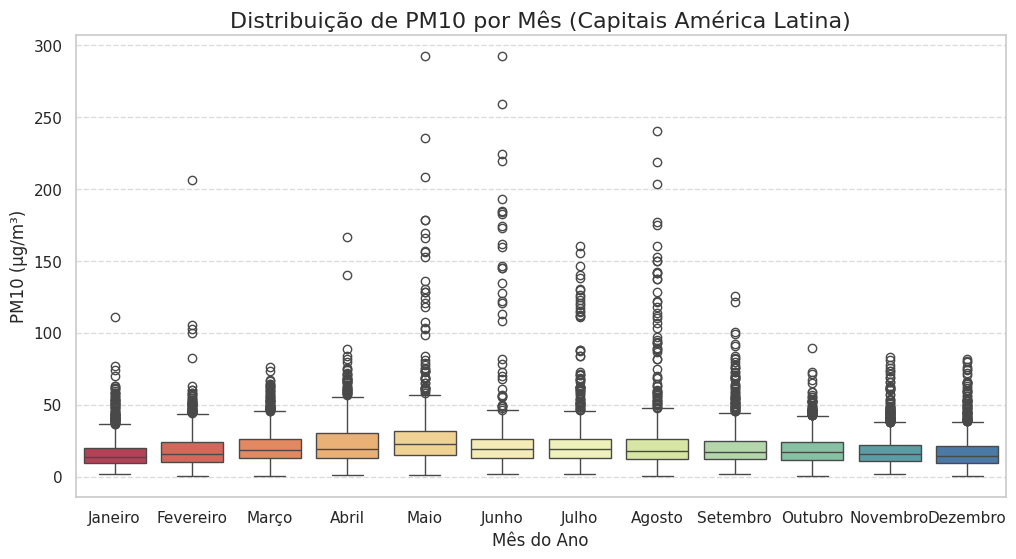

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




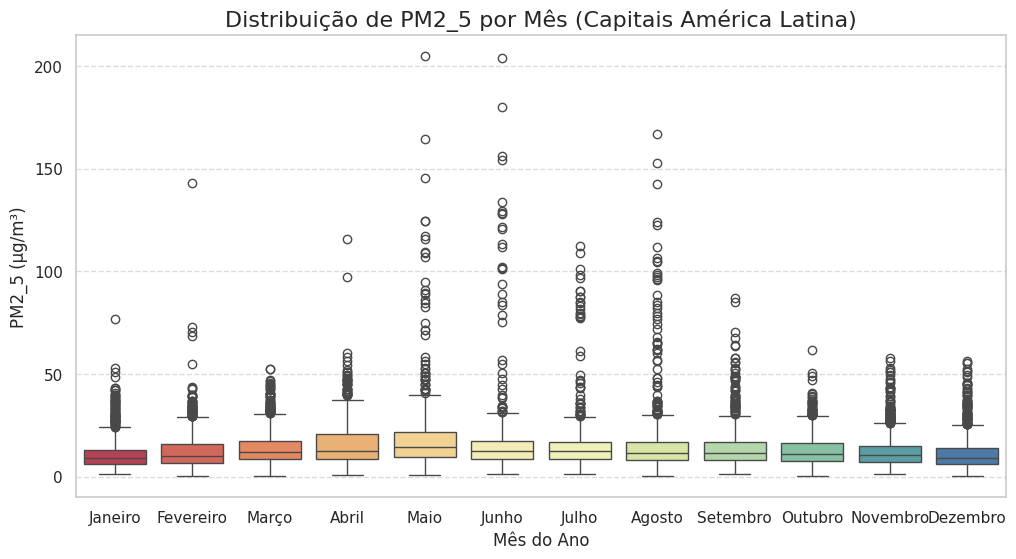

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




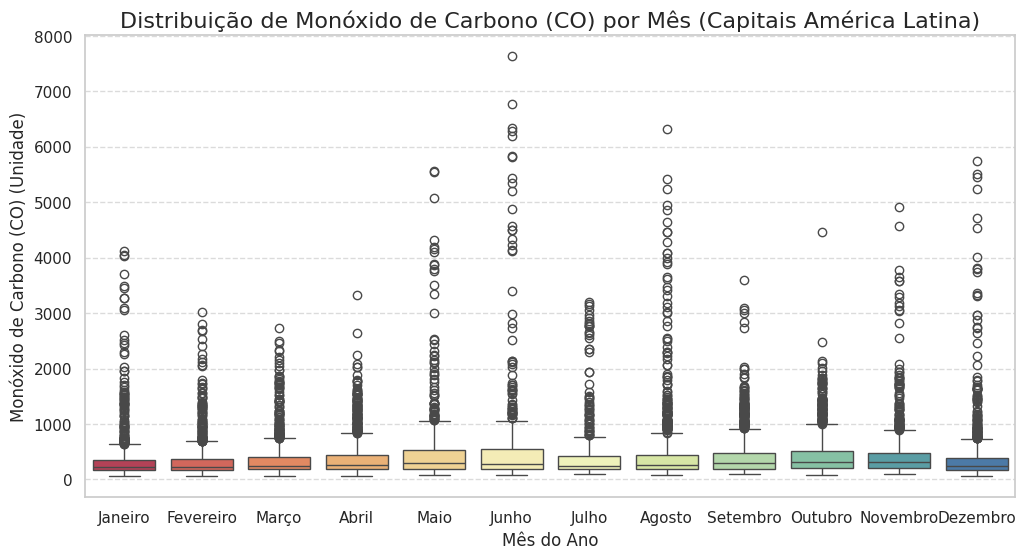

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




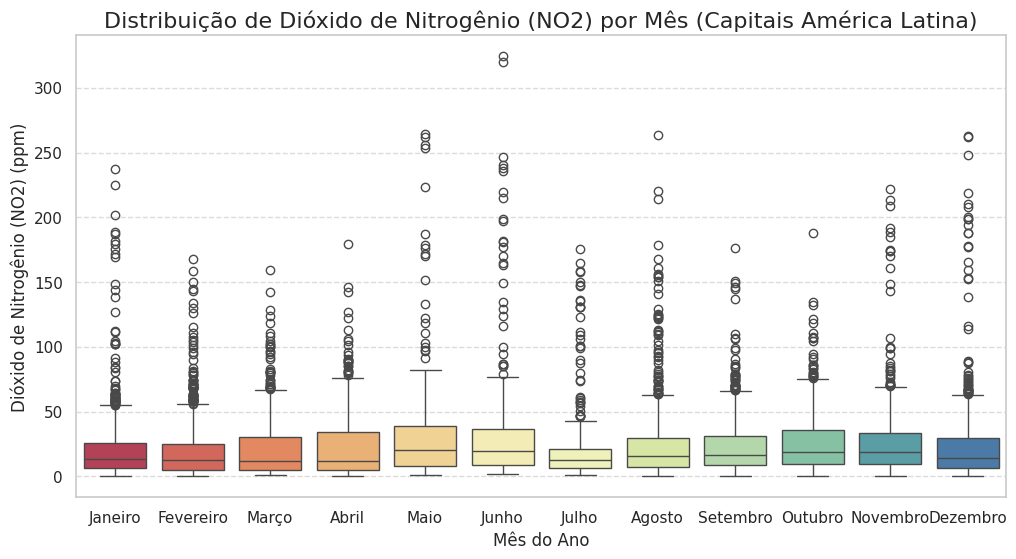

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




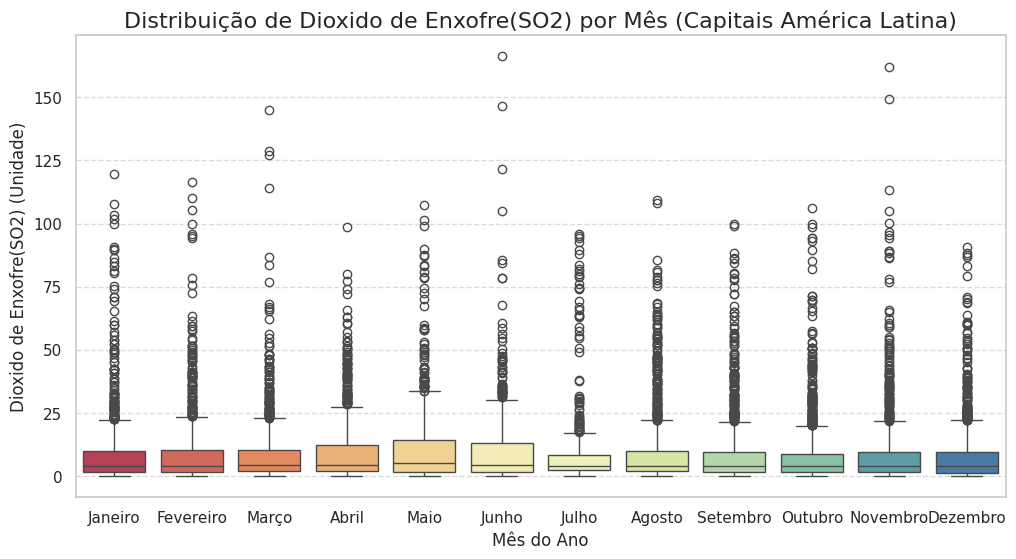

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




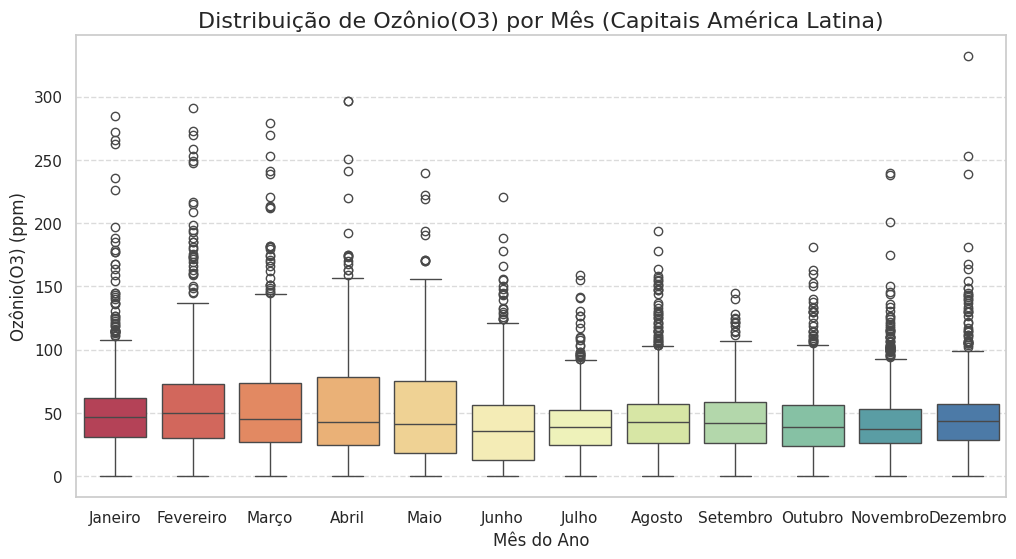

In [ ]:
# --- 0. PRÉ-PROCESSAMENTO DE DADOS (Manter a extração de data) ---

# 1. Garantir que a coluna 'Data' seja do tipo datetime
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')
# Não filtramos o PM10 ainda, pois faremos isso dinamicamente no loop
df_sazonal = dados_clima.dropna(subset=['Data']).copy()

# 2. DEFINIÇÃO DOS DICIONÁRIOS DE TRADUÇÃO
traducao_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
# Extração das colunas em Português
df_sazonal['Mês_Nome'] = df_sazonal['Data'].dt.month.map(traducao_meses)
ordem_meses_pt = list(traducao_meses.values())

# 3. IDENTIFICAÇÃO DOS INDICADORES
# Lista de colunas que representam indicadores de poluição na sua base
indicadores_poluicao = ['PM10', 'PM2_5', 'Monóxido de Carbono (CO)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']

# Mapeamento de unidade e título (para o gráfico ficar mais limpo)
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO2)': 'ppm',
    'Dióxido de Enxofre(SO2)':'ppm'
}

# --- 4. FUNÇÃO PARA GERAR O GRÁFICO POR INDICADOR ---

def plot_sazonal_por_indicador(df, indicador, ordem_eixo, unidade):
    # Remove NaN apenas para a coluna do indicador atual
    df_plot = df.dropna(subset=[indicador, 'Mês_Nome'])

    if df_plot.empty:
        print(f"Aviso: Não há dados válidos para o indicador {indicador}.")
        return

    plt.figure(figsize=(12, 6))

    sns.boxplot(
        data=df_plot,
        x='Mês_Nome',
        y=indicador,
        order=ordem_eixo,
        palette='Spectral'
    )

    # Cria o título e rótulo dinamicamente
    titulo = f'Distribuição de {indicador} por Mês (Capitais América Latina)'
    eixo_y = f'{indicador} ({unidade.get(indicador, "Unidade")})'

    plt.title(titulo, fontsize=16)
    plt.xlabel('Mês do Ano', fontsize=12)
    plt.ylabel(eixo_y, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# --- 5. EXECUÇÃO DO LOOP ---

for indicador in indicadores_poluicao:
    # Obtém a unidade do indicador atual ou usa um valor padrão
    unidade_atual = unidades.get(indicador, 'Unidade')

    # Chama a função para gerar o gráfico Box Plot do Mês
    plot_sazonal_por_indicador(df_sazonal, indicador, ordem_meses_pt, unidades)

In [ ]:
df_sazonal

Data  Latitude  Longitude  PM10  PM2_5  \
0     2022-07-29 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
1     2022-07-30 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
2     2022-07-31 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
3     2022-08-01 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
4     2022-08-02 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
...                         ...       ...        ...   ...    ...   
12635 2024-04-16 00:00:00+00:00   10.4806   -66.9036   9.3    6.1   
12636 2024-04-17 00:00:00+00:00   10.4806   -66.9036  28.5   19.6   
12637 2024-04-18 00:00:00+00:00   10.4806   -66.9036  23.1   16.2   
12638 2024-04-19 00:00:00+00:00   10.4806   -66.9036  40.7   29.1   
12639 2024-04-20 00:00:00+00:00   10.4806   -66.9036  15.1   10.7   

       Monóxido de Carbono (CO)  Dióxido de Nitrogênio (NO2)  \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   
3                           NaN                          NaN   
4                           NaN                          NaN   
...                         ...                          ...   
12635                     232.0                          7.3   
12636                     510.0                         18.5   
12637                     446.0                         14.2   
12638                     775.0                         26.5   
12639                     491.0                         18.0   

       Dioxido de Enxofre(SO2)  Ozônio(O3) Mês_Nome  
0                          NaN         NaN    Julho  
1                          NaN         NaN    Julho  
2                          NaN         NaN    Julho  
3                          NaN         NaN   Agosto  
4                          NaN         NaN   Agosto  
...                        ...         ...      ...  
12635                      2.1        41.0    Abril  
12636                      3.4        36.0    Abril  
12637                      3.2        58.0    Abril  
12638                      5.6        49.0    Abril  
12639                      3.4        31.0    Abril  

[12640 rows x 10 columns]

1- Como a qualidade do ar em Brasília se compara com a das capitais de outros países como Chile, Colômbia ou Argentina?

In [ ]:
# Obter coordenadas únicas
coordenadas_unicas = dados_clima[['Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)

# Usar a API Nominatim (OpenStreetMap)
geolocator = Nominatim(user_agent="qualidade_ar_analise")
nomes = []

print("🔎 Consultando cidades... (pode demorar um pouco)")
for i, row in coordenadas_unicas.iterrows():
    try:
        location = geolocator.reverse((row['Latitude'], row['Longitude']), language='pt')
        if location and 'address' in location.raw:
            cidade = (location.raw['address'].get('city') or
                      location.raw['address'].get('town') or
                      location.raw['address'].get('state') or
                      "Desconhecida")
        else:
            cidade = "Desconhecida"
        nomes.append(cidade)
        print(f"→ {row['Latitude']}, {row['Longitude']} → {cidade}")
    except Exception as e:
        print(f"⚠️ Erro em {i}: {e}")
        nomes.append("Erro")
    time.sleep(1)  # evita bloqueio de requisições pela API

coordenadas_unicas["Cidade"] = nomes

# Juntar as cidades ao DataFrame original
dados_clima = dados_clima.merge(coordenadas_unicas, on=["Latitude", "Longitude"], how="left")

# Converter o DataFrame para formato longo (ideal para gráficos)
dados_longos = dados_clima.melt(
    id_vars=["Cidade"],
    value_vars=['PM10', 'PM2_5', 'Monóxido de Carbono (CO)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)'],
    var_name="Indicador",
    value_name="Valor"
)

🔎 Consultando cidades... (pode demorar um pouco)
→ -34.6037, -58.3816 → Buenos Aires
→ -19.0196, -65.2619 → Sucre
→ -15.8267, -47.9218 → Brasília
→ -33.4378, -70.6504 → Região Metropolitana de Santiago
→ 4.711, -74.0721 → Bogotá
→ 9.9281, -84.0907 → San José
→ 23.1136, -82.3666 → La Habana
→ 18.4861, -69.9312 → São Domingos
→ -0.1807, -78.4678 → Quito
→ 13.6929, -89.2182 → São Salvador
→ 14.6349, -90.5069 → Cidade da Guatemala
→ 18.5944, -72.3074 → Porto Príncipe
→ 14.0723, -87.1921 → Tegucigalpa
→ 19.4326, -99.1332 → Cidade do México
→ 12.114, -86.2362 → Manágua
→ 8.9824, -79.5199 → Bella Vista
→ -25.2637, -57.5759 → Assunção
→ -12.0464, -77.0428 → Lima
→ -34.9011, -56.1645 → Montevidéu
→ 10.4806, -66.9036 → Caracas


✅ Indicadores prontos para histogramas: ['PM10', 'PM2_5', 'Monóxido de Carbono (CO)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']


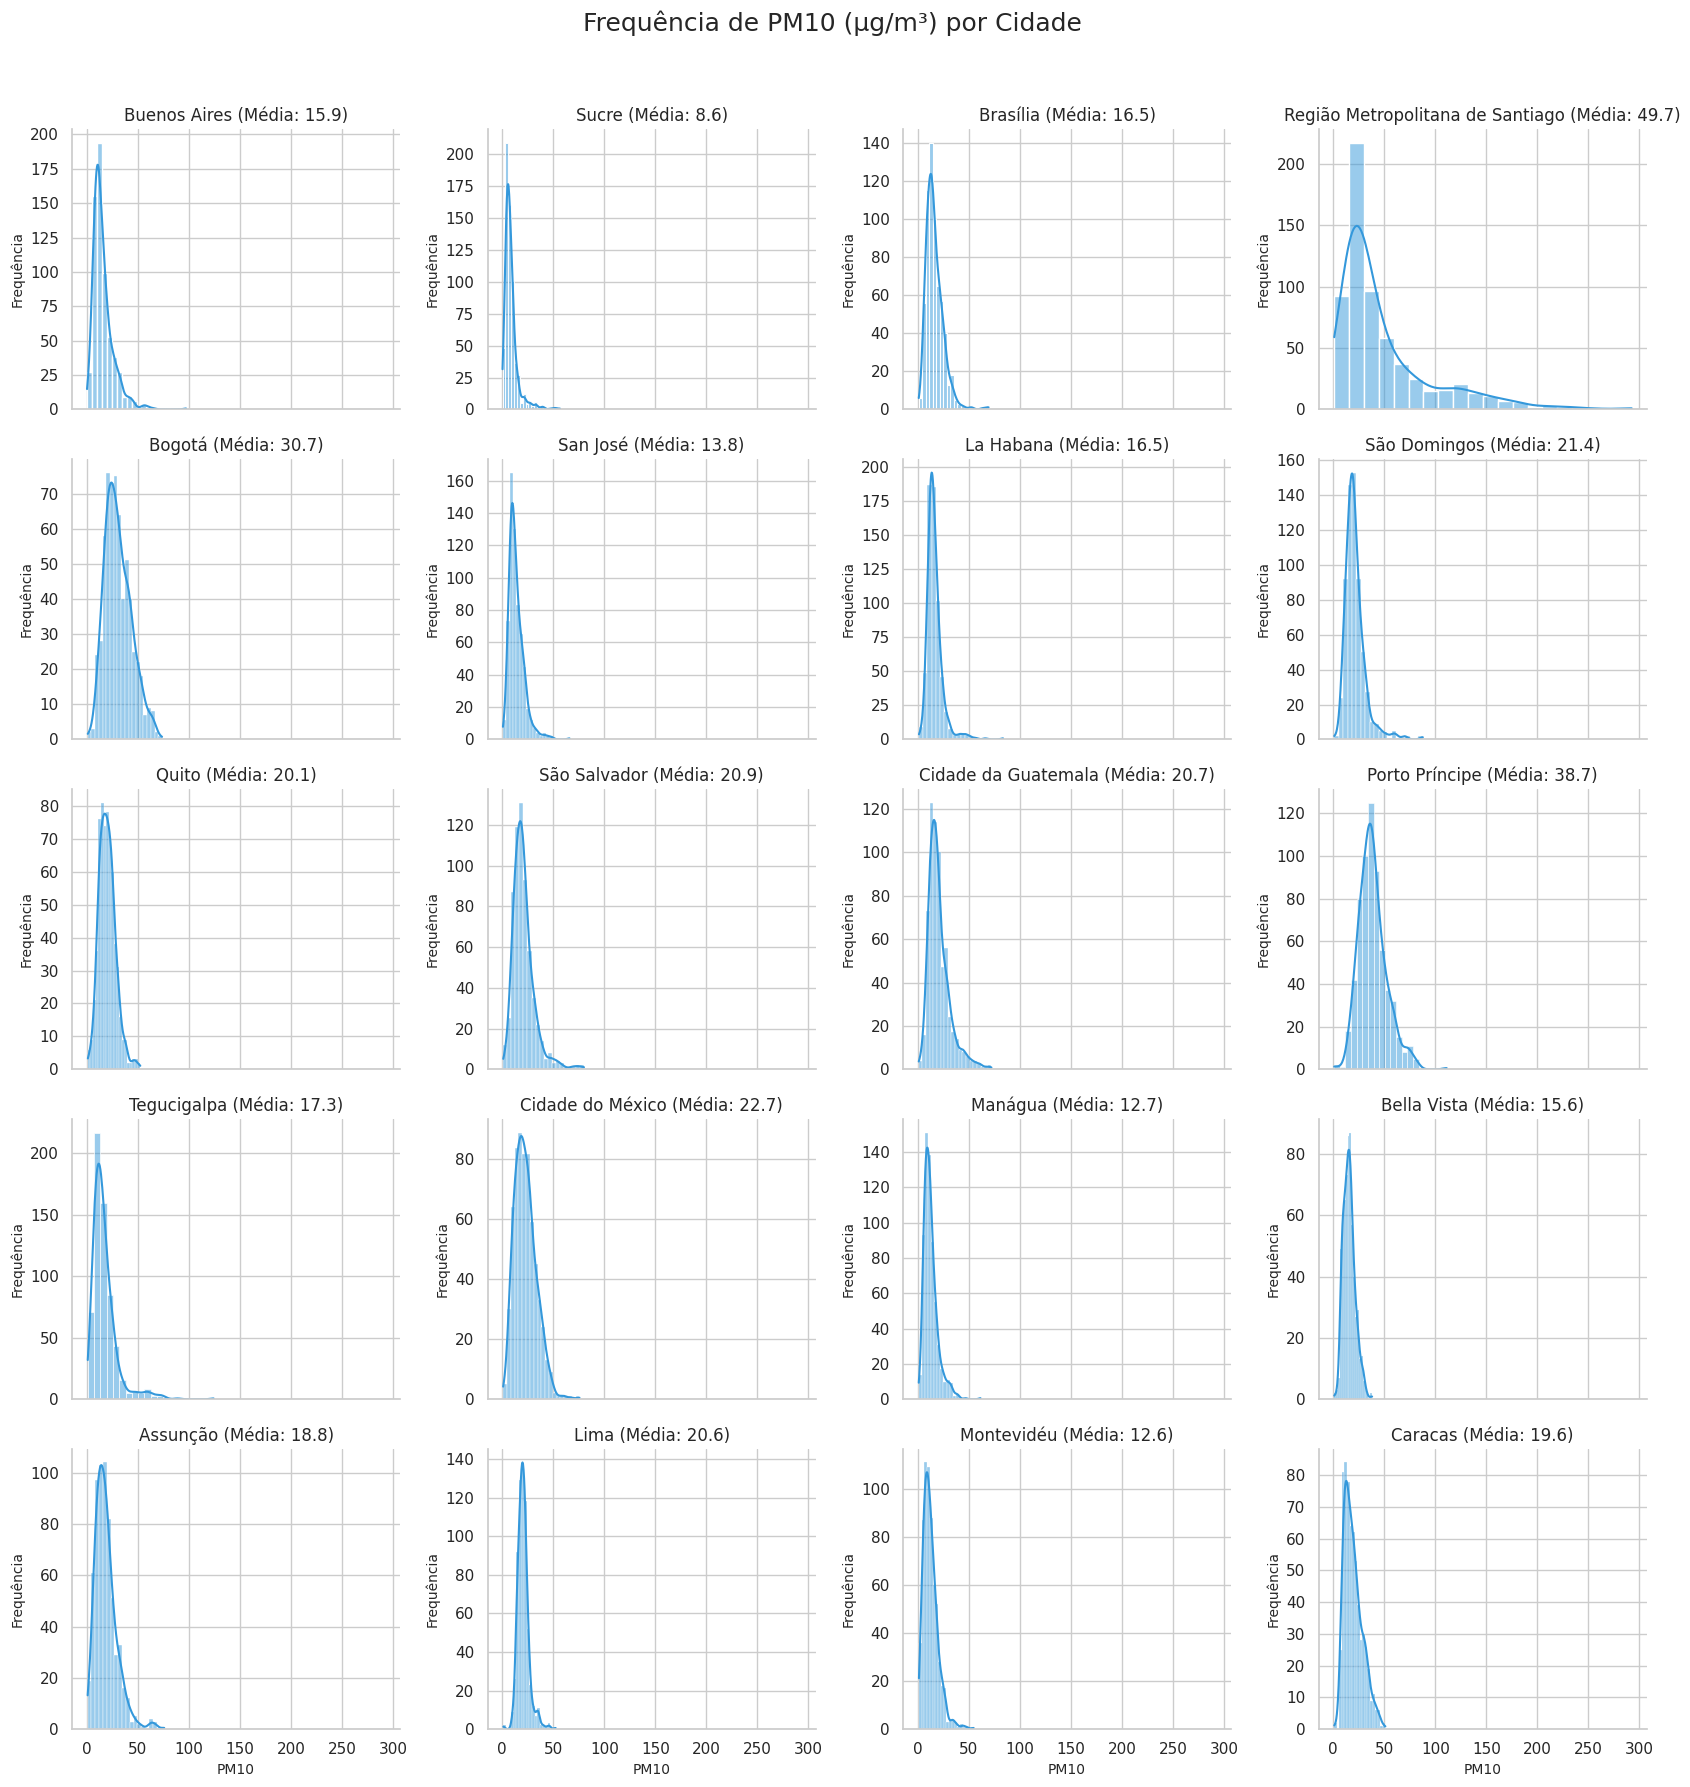

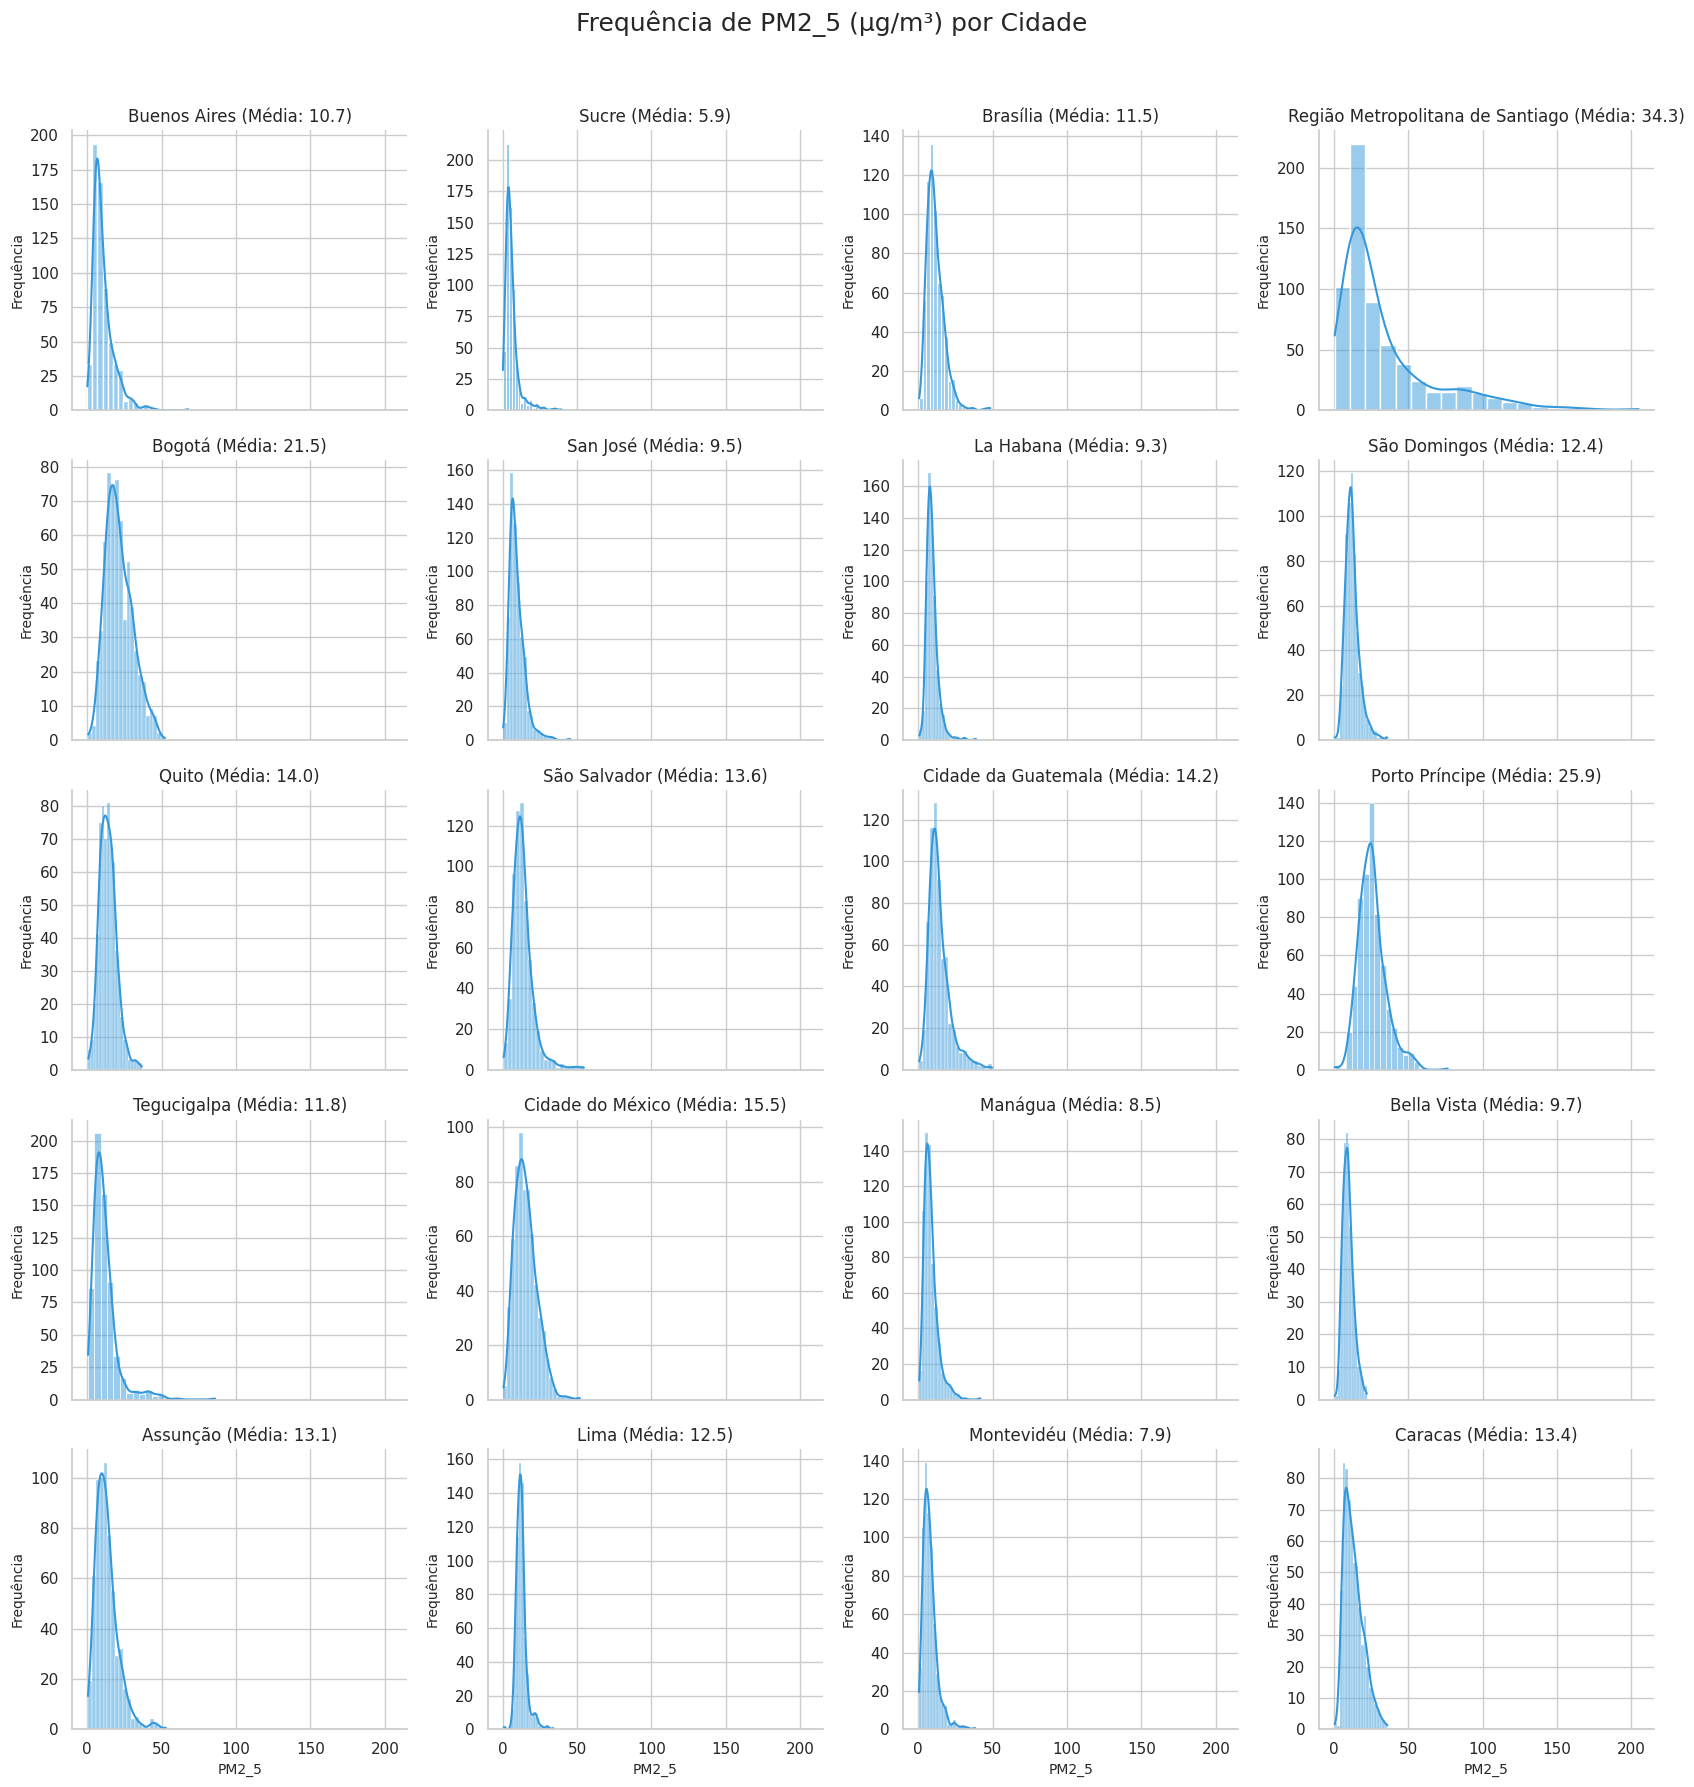

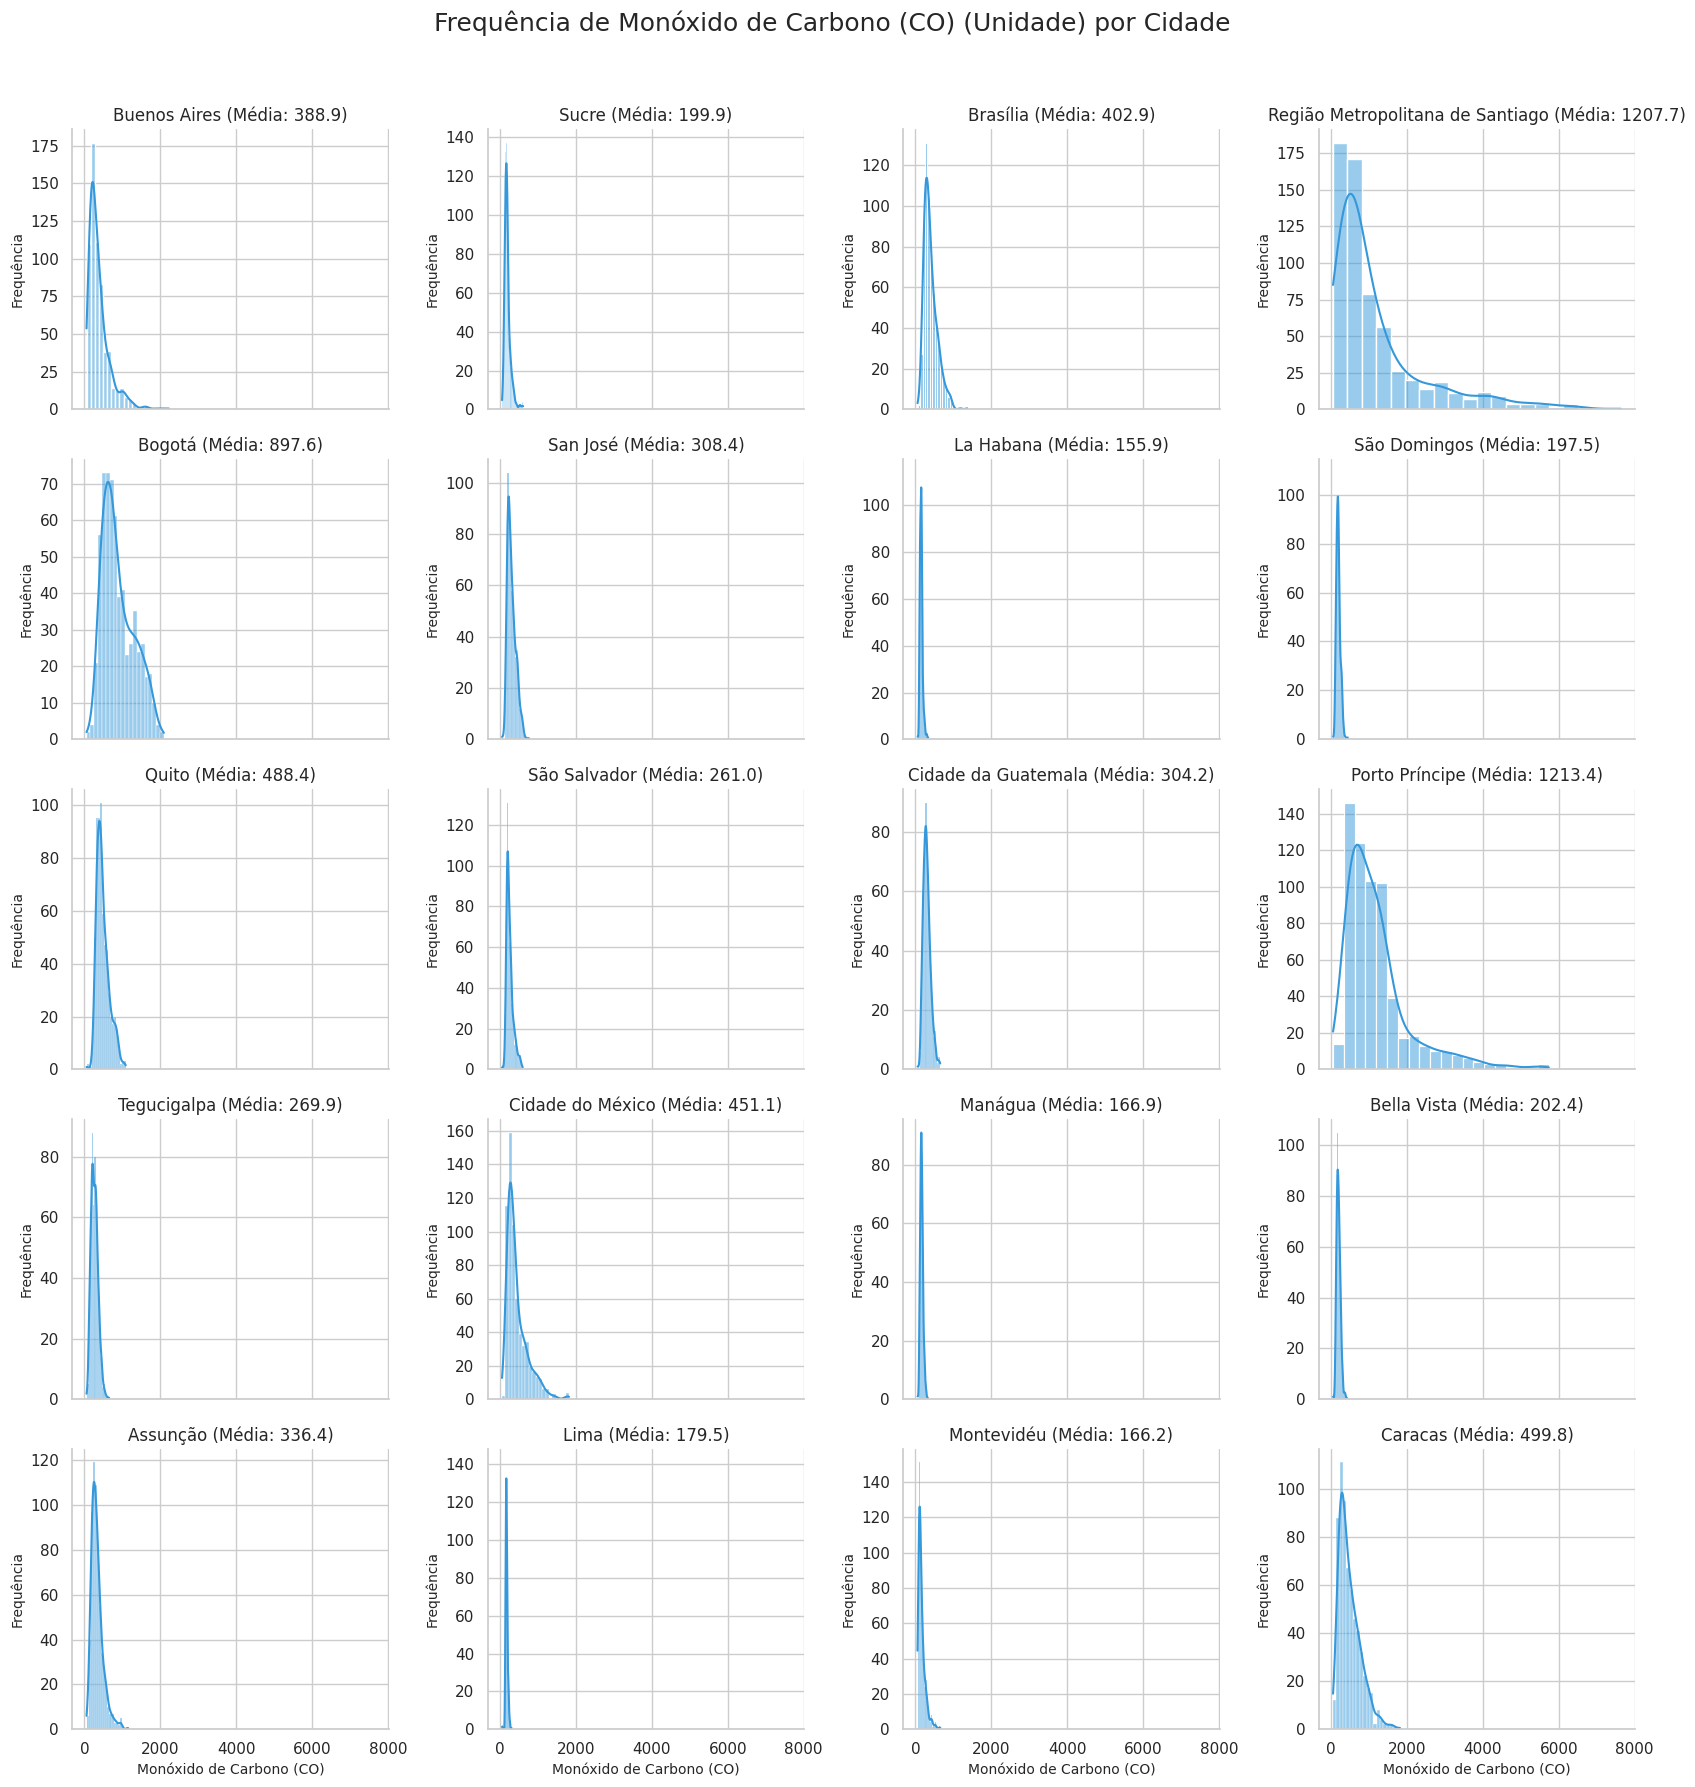

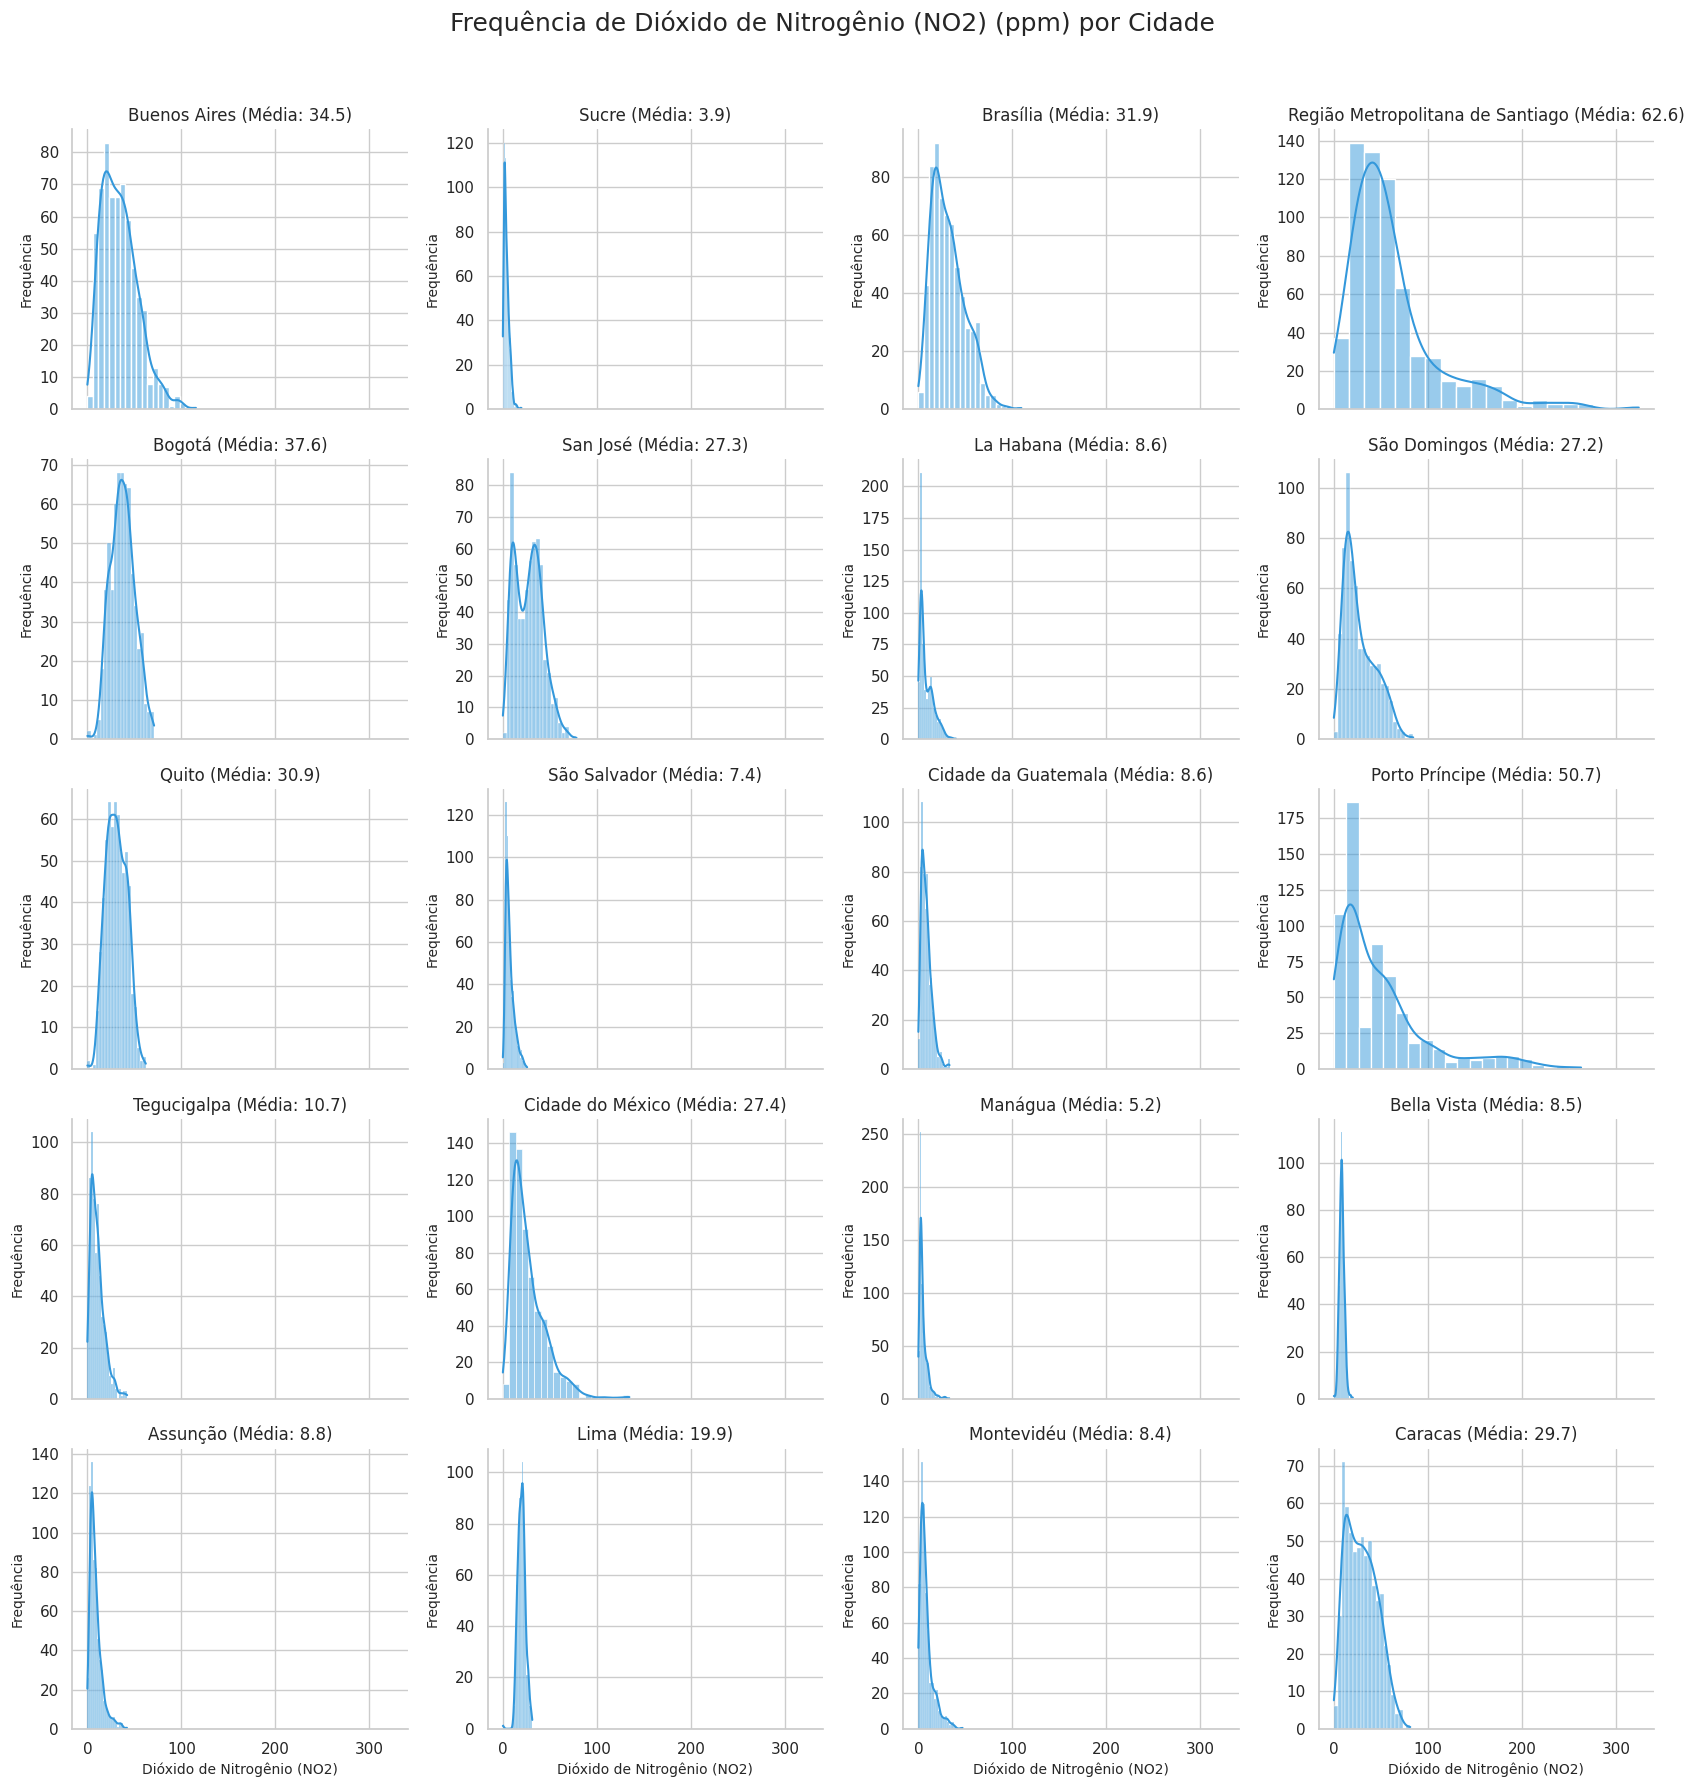

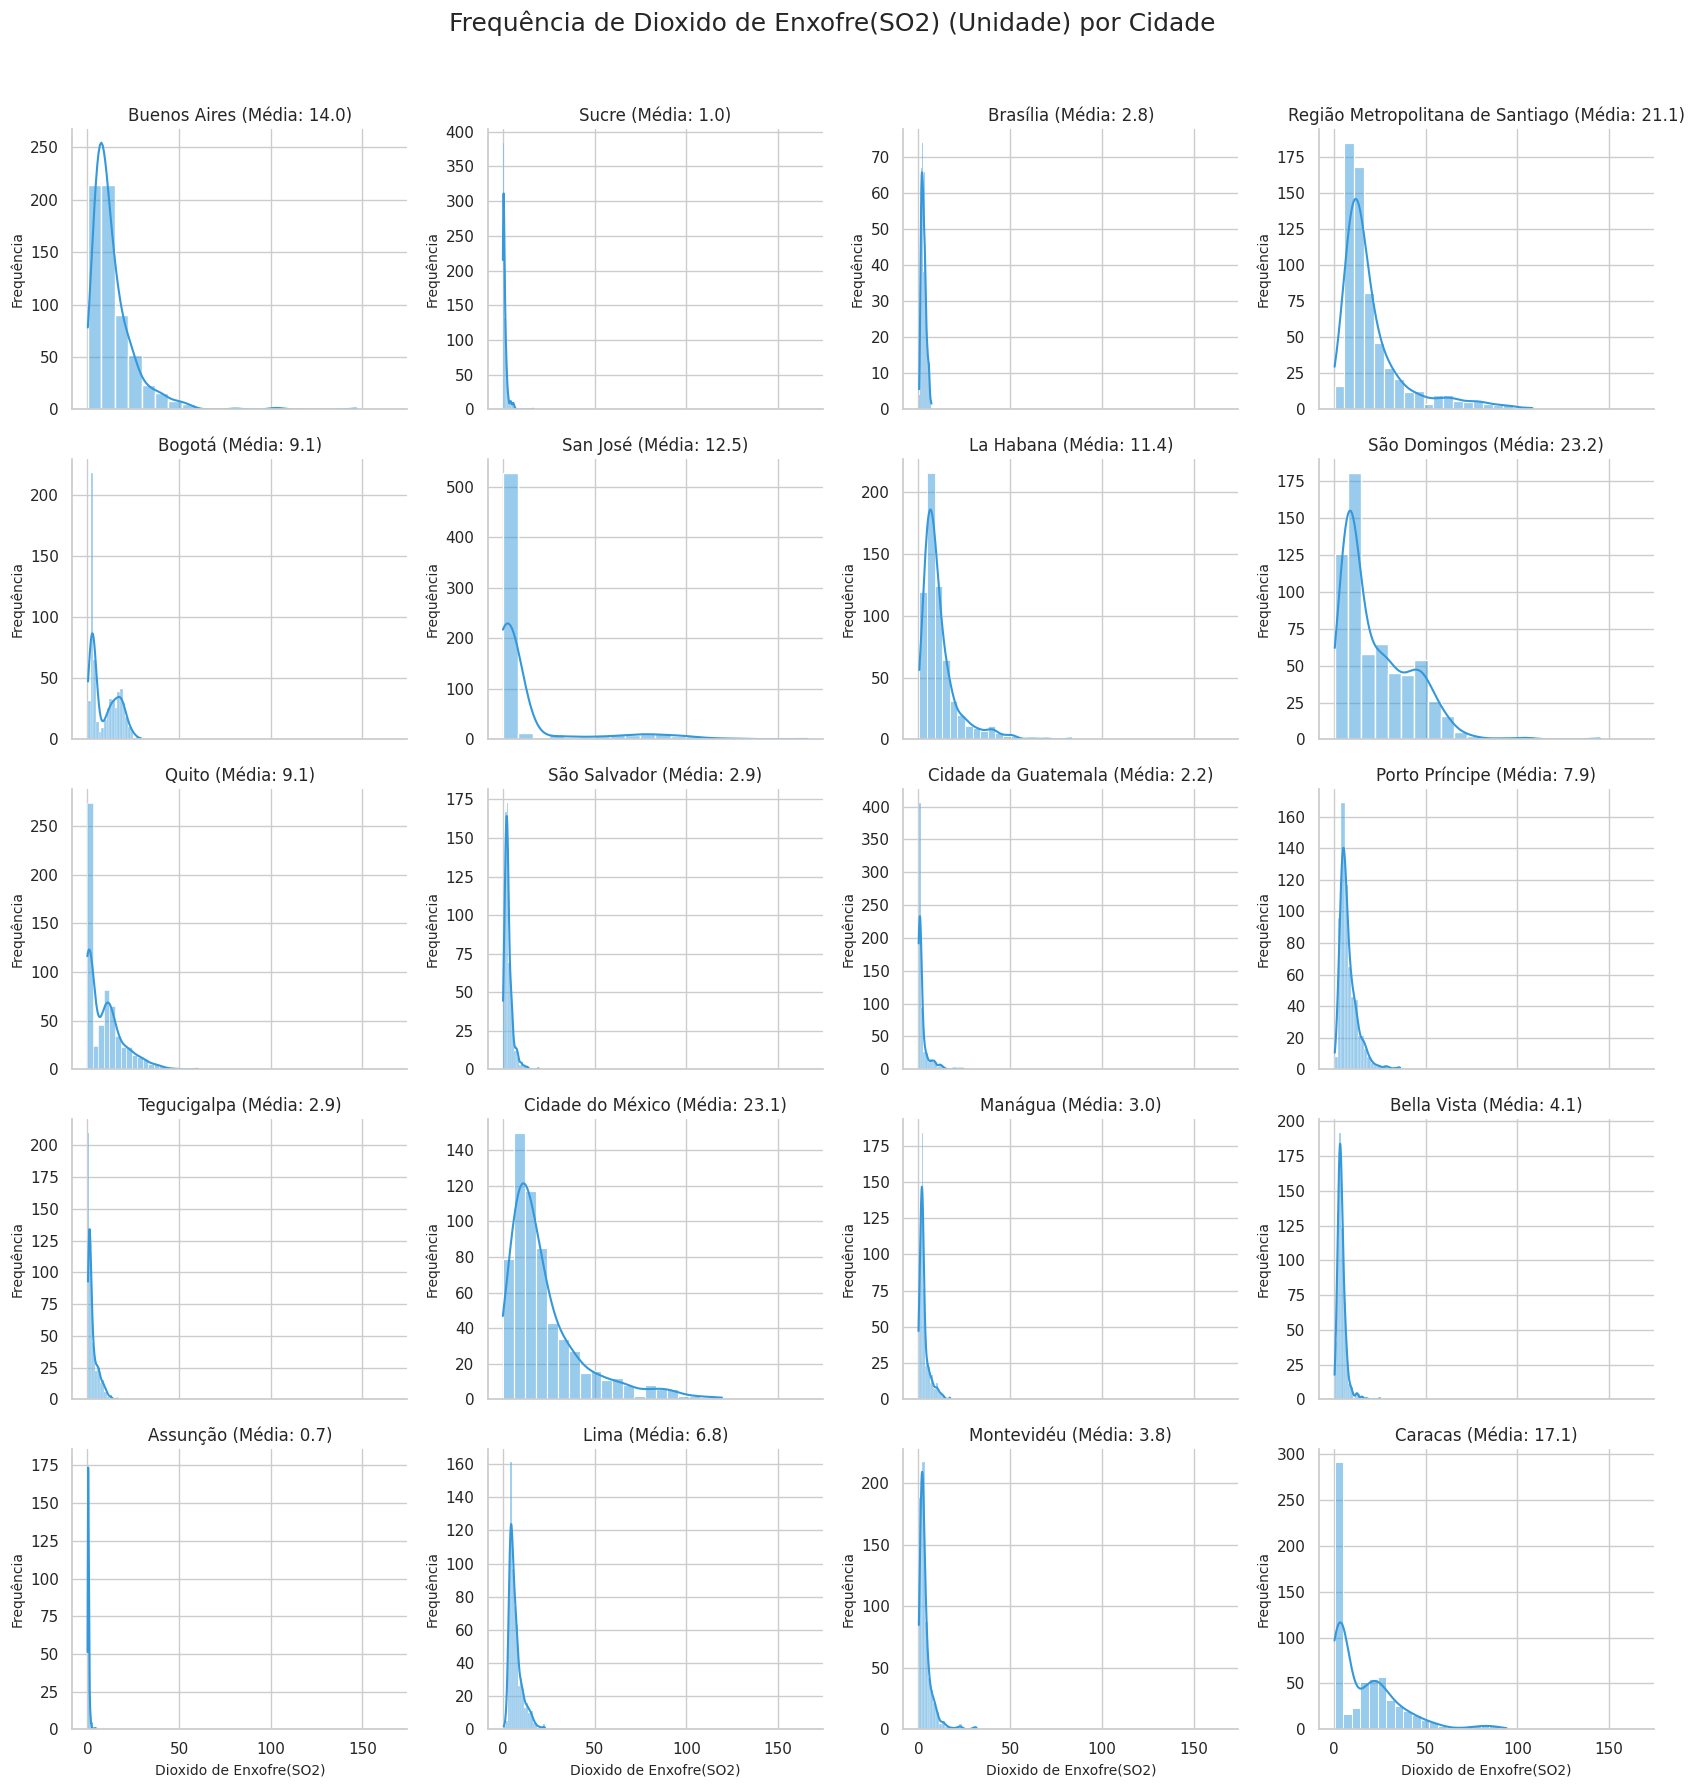

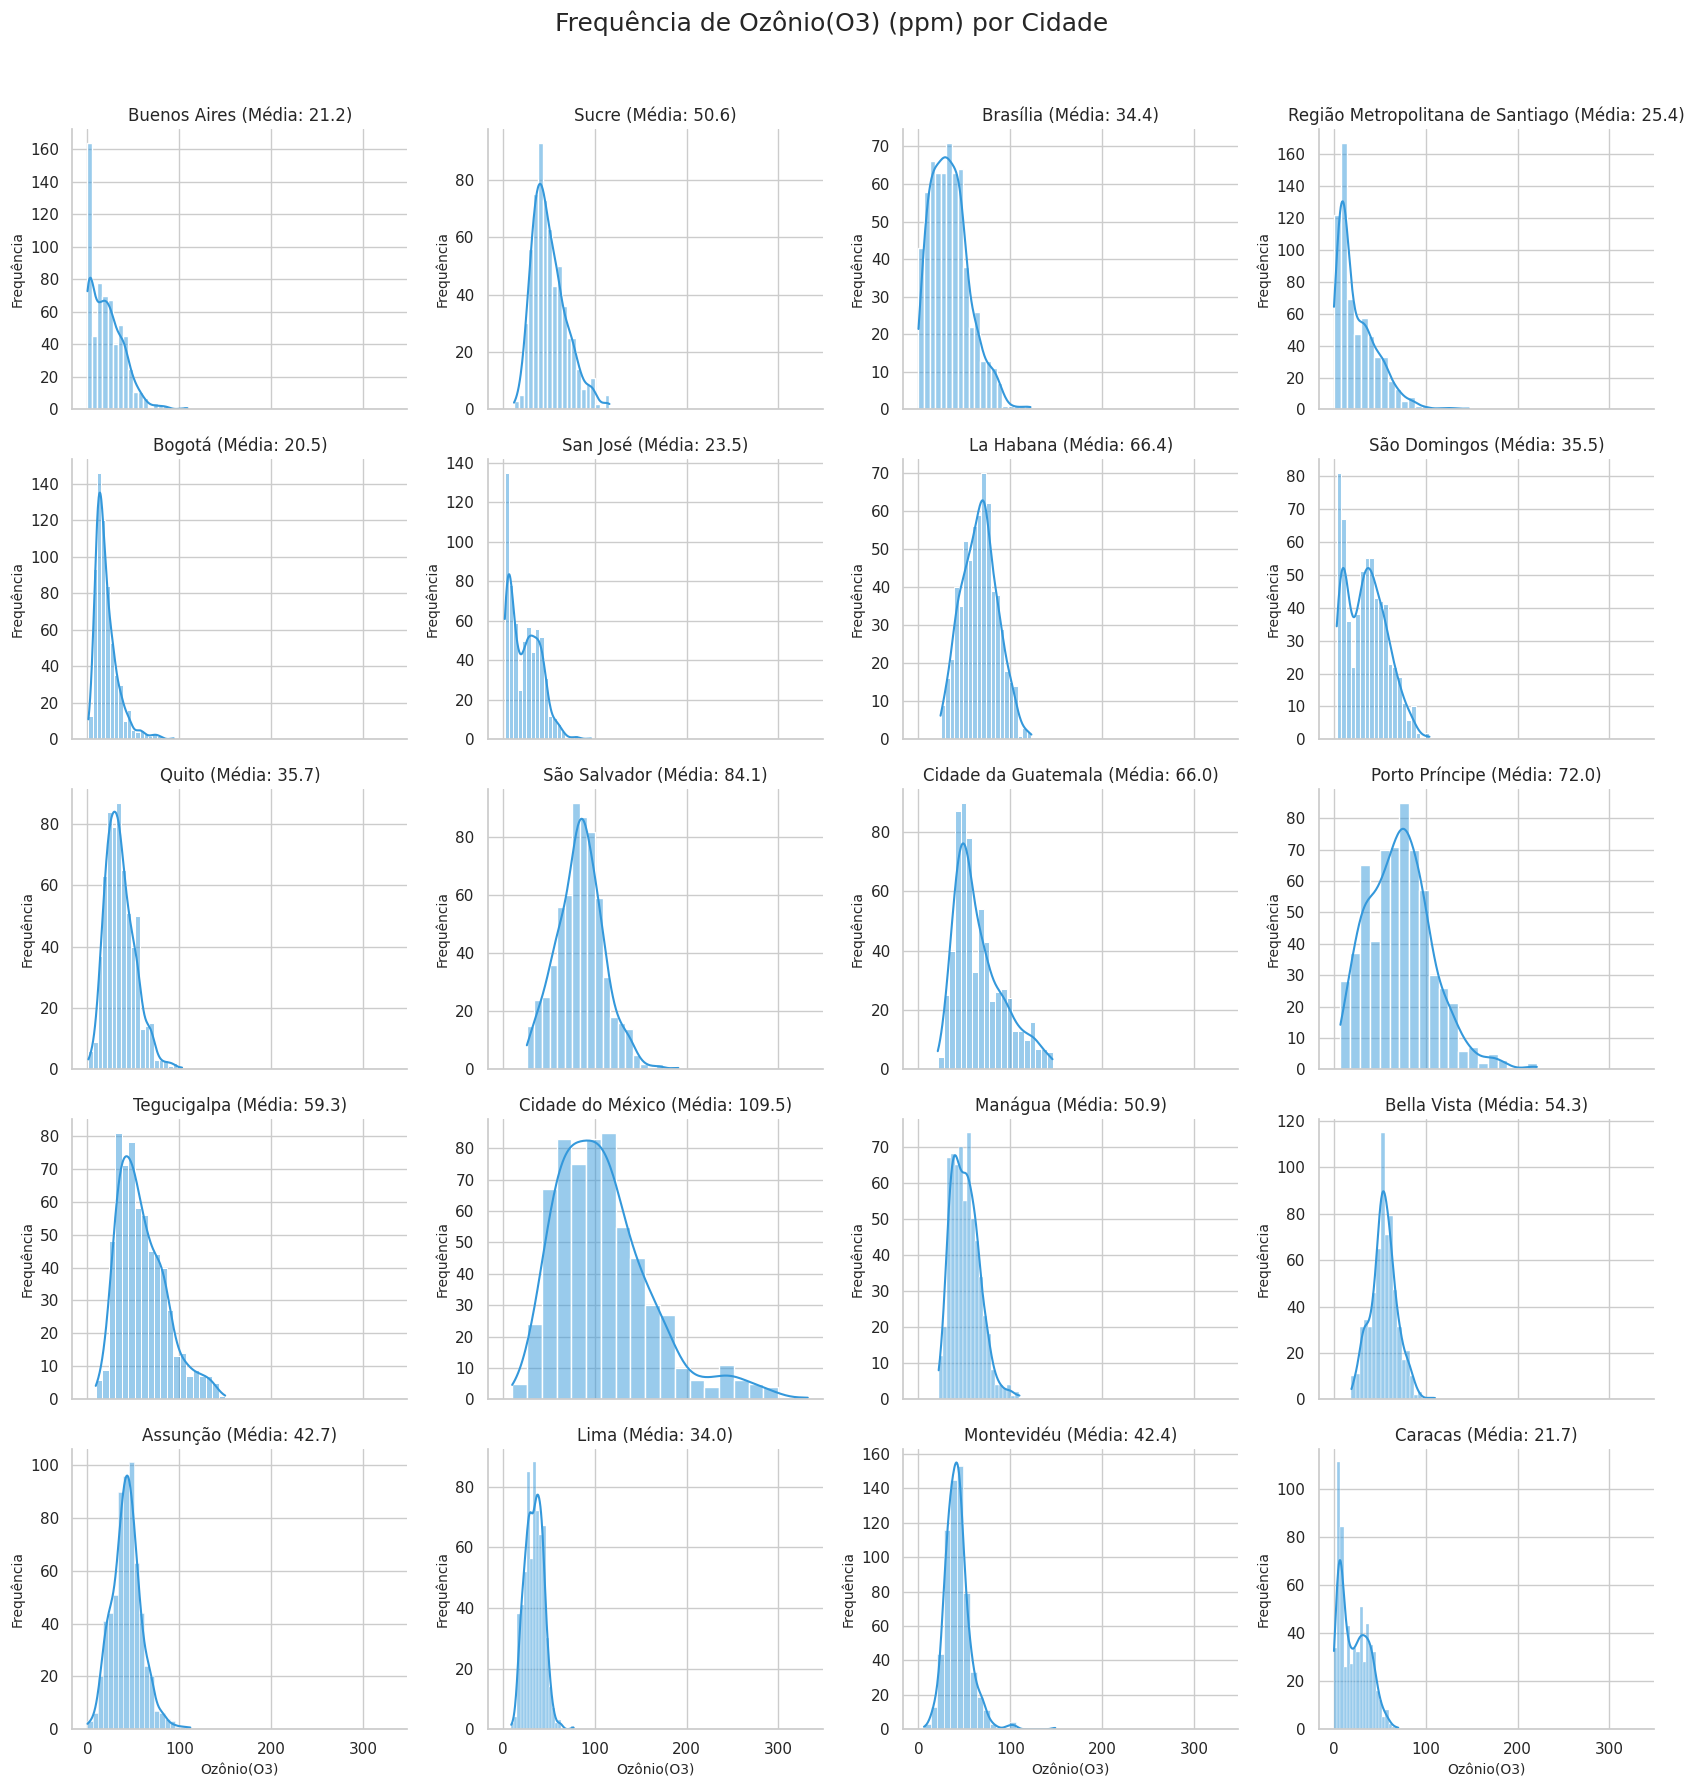

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. PREPARAÇÃO DE DADOS ---

# 1. Garantir que a coluna 'Data' seja do tipo datetime (necessário para a próxima fase de EDA, mas mantemos)
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')
df_plot = dados_clima.dropna(subset=['Cidade']).copy()

# 2. IDENTIFICAÇÃO DOS INDICADORES (Ajuste esta lista conforme seu DataFrame)
indicadores_candidatos = ['PM10', 'PM2_5', 'Monóxido de Carbono (CO)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']
colunas_disponiveis = df_plot.columns.tolist()
indicadores_poluicao = [ind for ind in indicadores_candidatos if ind in colunas_disponiveis]

# Mapeamento de unidade e título (para o gráfico ficar mais limpo)
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO2)': 'ppm',
    'Dióxido de Enxofre(SO2)':'ppm'
}

print(f"✅ Indicadores prontos para histogramas: {indicadores_poluicao}")

# --- 3. FUNÇÃO PARA GERAR O HISTOGRAMA COM FACETAMENTO POR CIDADE ---

def plot_histogramas_facetados(df, indicador, unidade):

    # Remove NaN apenas para o indicador atual e a cidade
    df_indicador = df.dropna(subset=[indicador, 'Cidade'])

    if df_indicador.empty:
        print(f"Aviso: Não há dados válidos para o indicador {indicador}. Gráfico ignorado.")
        return

    # Define o número de cidades e o tamanho do grid
    n_cidades = df_indicador['Cidade'].nunique()
    # Ajuste o tamanho da figura para acomodar o número de cidades (ex: 2 linhas, N/2 colunas)
    cols = min(4, n_cidades) # Máximo de 4 colunas
    rows = int(np.ceil(n_cidades / cols))

    # O FacetGrid é ideal para criar painéis de subplots baseados em uma categoria (Cidade)
    g = sns.FacetGrid(
        df_indicador,
        col="Cidade",
        col_wrap=cols, # Número de colunas no grid
        sharey=False,  # Permite que o eixo Y seja diferente para cada cidade (melhor para distribuição)
        height=3.5,
        aspect=1.2 # Aspecto mais largo
    )

    # Mapeia a função de histograma para cada painel
    g.map(
        sns.histplot,
        indicador,
        kde=True, # Adiciona a curva de densidade (suaviza a distribuição)
        bins=20,  # Número de caixas/intervalos
        color="#3498db" # Cor de fundo
    )

    # Adiciona títulos e ajusta layout
    titulo_principal = f'Frequência de {indicador} ({unidade.get(indicador, "Unidade")}) por Cidade'
    g.fig.suptitle(titulo_principal, fontsize=18, y=1.02)

    # Ajusta os rótulos de cada subplot (opcional)
    for ax in g.axes.flat:
        ax.set_xlabel(indicador, fontsize=10)
        ax.set_ylabel("Frequência", fontsize=10)
        # Adiciona a média no título do subplot para referência
        media = df_indicador.loc[df_indicador['Cidade'] == ax.get_title().split('=')[1].strip(), indicador].mean()
        ax.set_title(f"{ax.get_title().split('=')[1].strip()} (Média: {media:.1f})")

    plt.tight_layout() # Garante que os títulos e rótulos não se sobreponham
    plt.show()


# --- 4. EXECUÇÃO DO LOOP ---

for indicador in indicadores_poluicao:
    plot_histogramas_facetados(df_plot, indicador, unidades)

2- Gráficos de violino no que diz respeito a cada indicador de ar considerando cada capital

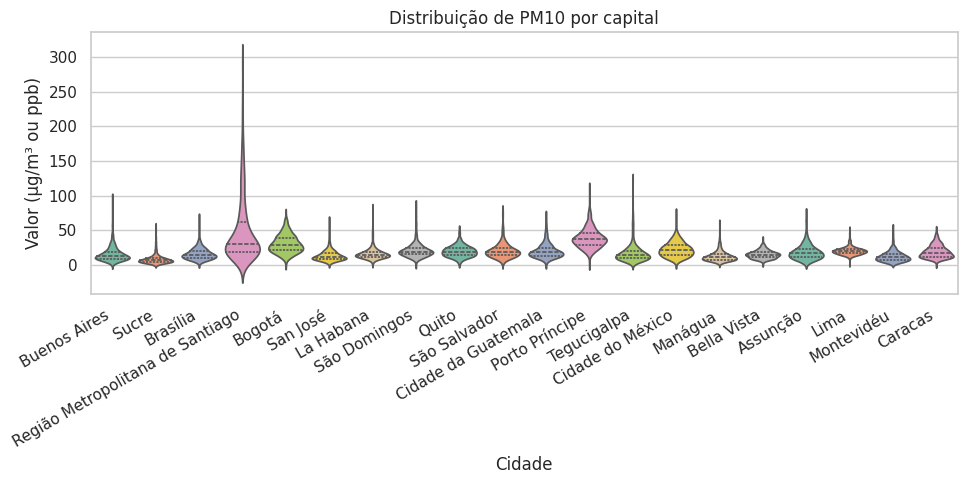

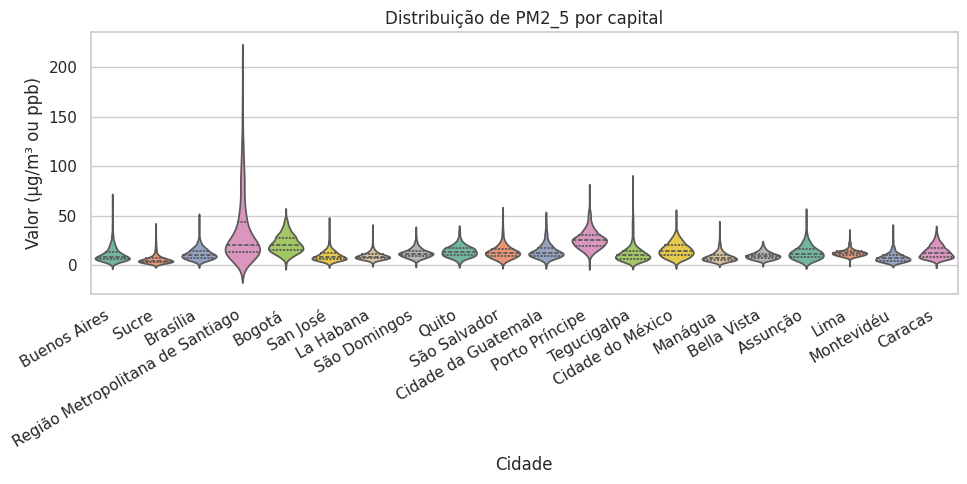

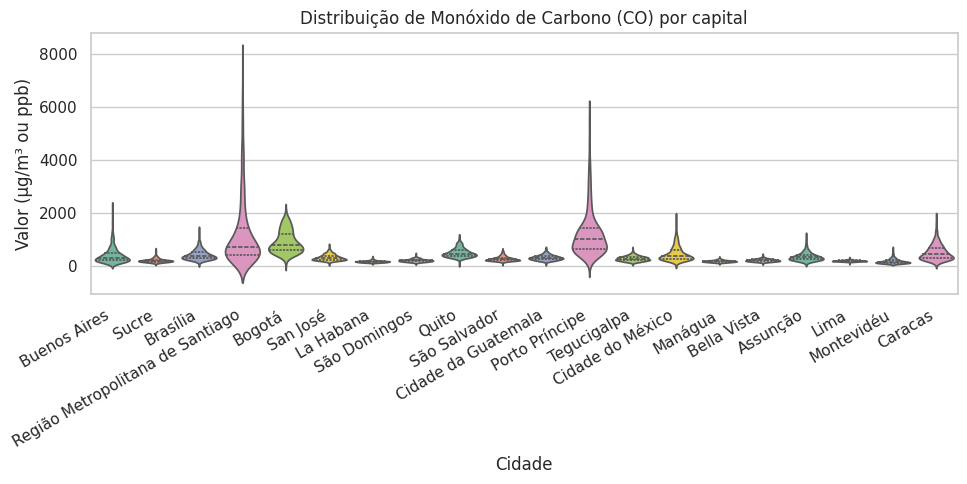

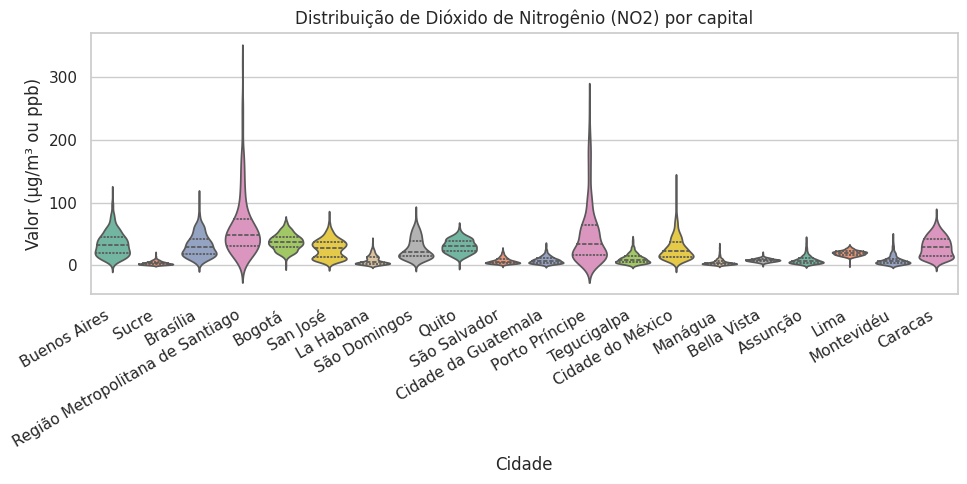

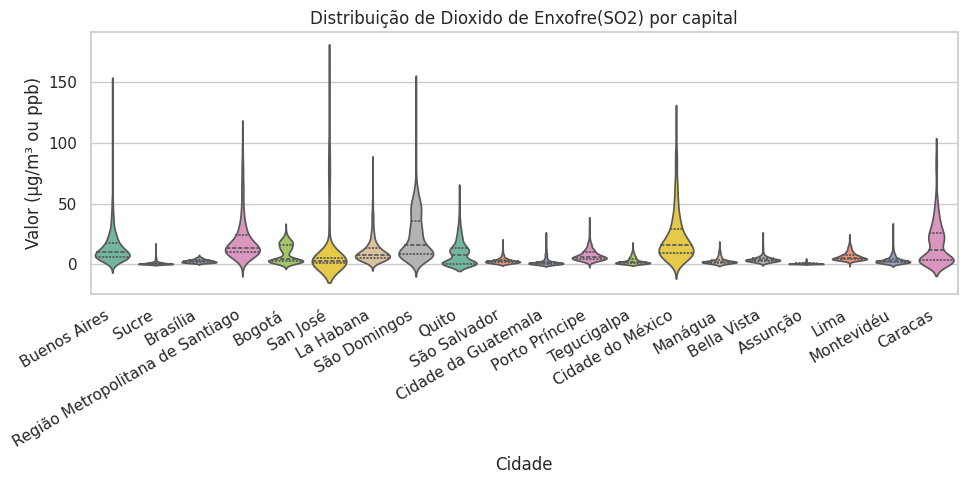

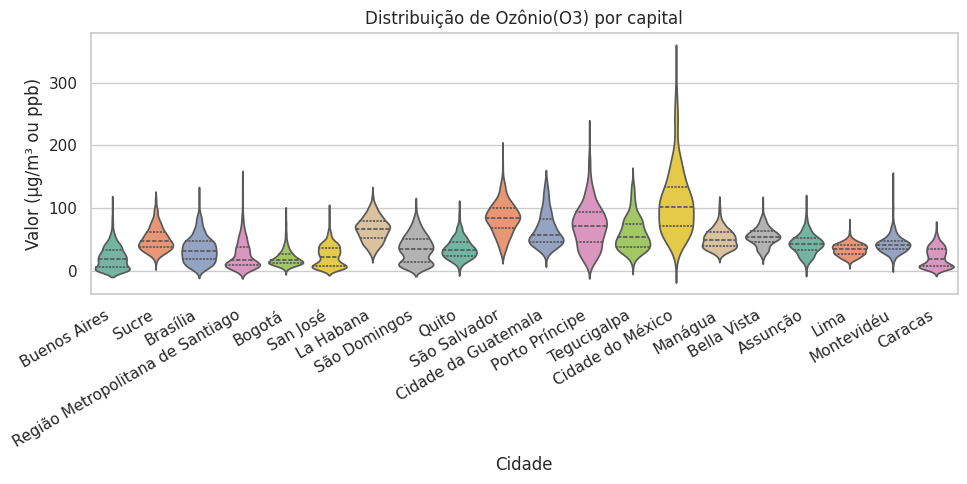

In [ ]:
# Garantir que só existam linhas válidas
dados_longos = dados_longos.dropna(subset=["Valor", "Cidade"])

# Configurações de estilo
sns.set(style="whitegrid")

# Gerar um gráfico separado para cada indicador
indicadores = dados_longos["Indicador"].unique()

for indicador in indicadores:
    plt.figure(figsize=(10, 5))

    sns.violinplot(
        data=dados_longos[dados_longos["Indicador"] == indicador],
        x="Cidade", y="Valor",
        hue="Cidade",      # cores diferentes por cidade
        inner="quartile",
        palette="Set2",
        dodge=False        # mantém violinos sobrepostos ou separados
    )




    plt.title(f"Distribuição de {indicador} por capital")
    plt.xlabel("Cidade")
    plt.ylabel("Valor (μg/m³ ou ppb)")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

3- fazer um calendário de heatmap pros niveis de ar e olhar se tem alguma sazonalidade de brasilia ou geral de tudo

In [ ]:
#Calendar Heatmap agrupado (média dos anos de 2022, 2023 e 2024) da concentração de gases nas capitais da América Latina, exceto Brasília
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

# Inicializa o modo offline
init_notebook_mode(connected=True)

# DICIONÁRIO DE UNIDADES
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO)': 'ppm',
    'Dioxido de Enxofre(SO2)':'ppm'
}

# LISTA DE INDICADORES
indicadores_poluicao = ['PM10', 'PM2_5', 'Monóxido de Carbono (CO)',
                        'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)',
                        'Ozônio(O3)']

# ORDENS DE EXIBIÇÃO
ordem_meses_pt = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho',
                  'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
ordem_dias_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira',
                 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

traducao_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}

dados_clima['Mês_Nome'] = dados_clima['Data'].dt.month.map(traducao_meses)

# Dicionário para traduzir o número do dia da semana (0=Segunda, 6=Domingo)
traducao_dias = {
    0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira',
    3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'
}

dados_clima['Dia_Semana_Nome'] = dados_clima['Data'].dt.dayofweek.map(traducao_dias)

# ----------------------------------------------------------------------
# LOOP PARA GERAR O CALENDÁRIO HEATMAP PARA CADA INDICADOR
# ----------------------------------------------------------------------

for indicador in indicadores_poluicao:
    # 1. TRATAMENTO DE DADOS E AGREGAÇÃO
    # Tenta obter a unidade, se não encontrar, usa uma string vazia
    unidade = unidades.get(indicador, '')

    # Agrupamento: Média do indicador por Mês e Dia da Semana
    df_heatmap = dados_clima.groupby(['Mês_Nome', 'Dia_Semana_Nome'])[indicador].mean().reset_index()

    # 2. PIVOTAGEM DOS DADOS
    # Transforma a tabela longa (long format) em matriz (matrix format)
    df_pivot = df_heatmap.pivot(index='Mês_Nome', columns='Dia_Semana_Nome', values=indicador)

    # 3. REORDENAR A TABELA PIVOTADA
    # Garante a ordem correta dos meses (índice) e dias (colunas)
    df_pivot = df_pivot.reindex(index=ordem_meses_pt, columns=ordem_dias_pt)

    # Verifica se há dados válidos para plotar
    if df_pivot.empty or df_pivot.isnull().all().all():
        print(f"Aviso: Não há dados suficientes ou válidos para o indicador '{indicador}'. Pulando.")
        continue

    # 4. CRIAÇÃO DO HEATMAP COM PLOTLY GRAPH OBJECTS
    fig = go.Figure(data=go.Heatmap(
            # Eixos
            x=df_pivot.columns,
            y=df_pivot.index,
            # Valores
            z=df_pivot.values,
            # Configuração de cor e barra de cor
            colorscale='plasma', # Você pode mudar o esquema de cor (ex: 'viridis', 'hot')
            colorbar=dict(title=f'{indicador} ({unidade})'),
            # Configuração de texto (média na célula)
            text=df_pivot.values.round(2),
            texttemplate="%{text}",
            # Configuração de informações ao passar o mouse (hover)
            hovertemplate=f'<b>Mês:</b> %{{y}}<br><b>Dia:</b> %{{x}}<br><b>Média:</b> %{{z:.2f}} {unidade}<extra></extra>'
    ))

    # 5. AJUSTES FINAIS DE LAYOUT
    fig.update_layout(
        title=f'Sazonalidade da Média de {indicador} ({unidade})<br>Por Mês e Dia da Semana',
        xaxis_title='Dia da Semana',
        yaxis_title='Mês',
        # Inverte o eixo Y para que Janeiro fique no topo e Dezembro na base
        yaxis={'categoryorder':'array', 'categoryarray':ordem_meses_pt, 'autorange':'reversed'}
    )

    # Exibe o gráfico atual
    fig.show()

In [ ]:
#Calendar Heatmap agrupado (média dos anos de 2022, 2023 e 2024) da concentração de gases em Brasília
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

# Inicializa o modo offline
init_notebook_mode(connected=True)

# DICIONÁRIO DE UNIDADES
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO2)': 'ppm',
    'Dioxido de Enxofre(SO2)':'ppm'
}

# LISTA DE INDICADORES
indicadores_poluicao = ['PM10', 'PM2_5', 'Monóxido de Carbono (CO)',
                        'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)',
                        'Ozônio(O3)']

# ORDENS DE EXIBIÇÃO
ordem_meses_pt = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho',
                  'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
ordem_dias_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira',
                 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

traducao_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}

dados_clima['Mês_Nome'] = dados_clima['Data'].dt.month.map(traducao_meses)

# Dicionário para traduzir o número do dia da semana (0=Segunda, 6=Domingo)
traducao_dias = {
    0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira',
    3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'
}

dados_clima['Dia_Semana_Nome'] = dados_clima['Data'].dt.dayofweek.map(traducao_dias)
df_plot=dados_clima[dados_clima['Cidade']=='Brasília']

# ----------------------------------------------------------------------
# LOOP PARA GERAR O CALENDÁRIO HEATMAP PARA CADA INDICADOR
# ----------------------------------------------------------------------

for indicador in indicadores_poluicao:
    # 1. TRATAMENTO DE DADOS E AGREGAÇÃO
    # Tenta obter a unidade, se não encontrar, usa uma string vazia
    unidade = unidades.get(indicador, '')

    # Agrupamento: Média do indicador por Mês e Dia da Semana
    df_heatmap = df_plot.groupby(['Mês_Nome', 'Dia_Semana_Nome'])[indicador].mean().reset_index()

    # 2. PIVOTAGEM DOS DADOS
    # Transforma a tabela longa (long format) em matriz (matrix format)
    df_pivot = df_heatmap.pivot(index='Mês_Nome', columns='Dia_Semana_Nome', values=indicador)

    # 3. REORDENAR A TABELA PIVOTADA
    # Garante a ordem correta dos meses (índice) e dias (colunas)
    df_pivot = df_pivot.reindex(index=ordem_meses_pt, columns=ordem_dias_pt)

    # Verifica se há dados válidos para plotar
    if df_pivot.empty or df_pivot.isnull().all().all():
        print(f"Aviso: Não há dados suficientes ou válidos para o indicador '{indicador}'. Pulando.")
        continue

    # 4. CRIAÇÃO DO HEATMAP COM PLOTLY GRAPH OBJECTS
    fig = go.Figure(data=go.Heatmap(
            # Eixos
            x=df_pivot.columns,
            y=df_pivot.index,
            # Valores
            z=df_pivot.values,
            # Configuração de cor e barra de cor
            colorscale='plasma', # Você pode mudar o esquema de cor (ex: 'viridis', 'hot')
            colorbar=dict(title=f'{indicador} ({unidade})'),
            # Configuração de texto (média na célula)
            text=df_pivot.values.round(2),
            texttemplate="%{text}",
            # Configuração de informações ao passar o mouse (hover)
            hovertemplate=f'<b>Mês:</b> %{{y}}<br><b>Dia:</b> %{{x}}<br><b>Média:</b> %{{z:.2f}} {unidade}<extra></extra>'
    ))

    # 5. AJUSTES FINAIS DE LAYOUT
    fig.update_layout(
        title=f'Sazonalidade da Média de {indicador} ({unidade})<br>Por Mês e Dia da Semana em Brasília',
        xaxis_title='Dia da Semana',
        yaxis_title='Mês',
        # Inverte o eixo Y para que Janeiro fique no topo e Dezembro na base
        yaxis={'categoryorder':'array', 'categoryarray':ordem_meses_pt, 'autorange':'reversed'}
    )

    # Exibe o gráfico atual
    fig.show()

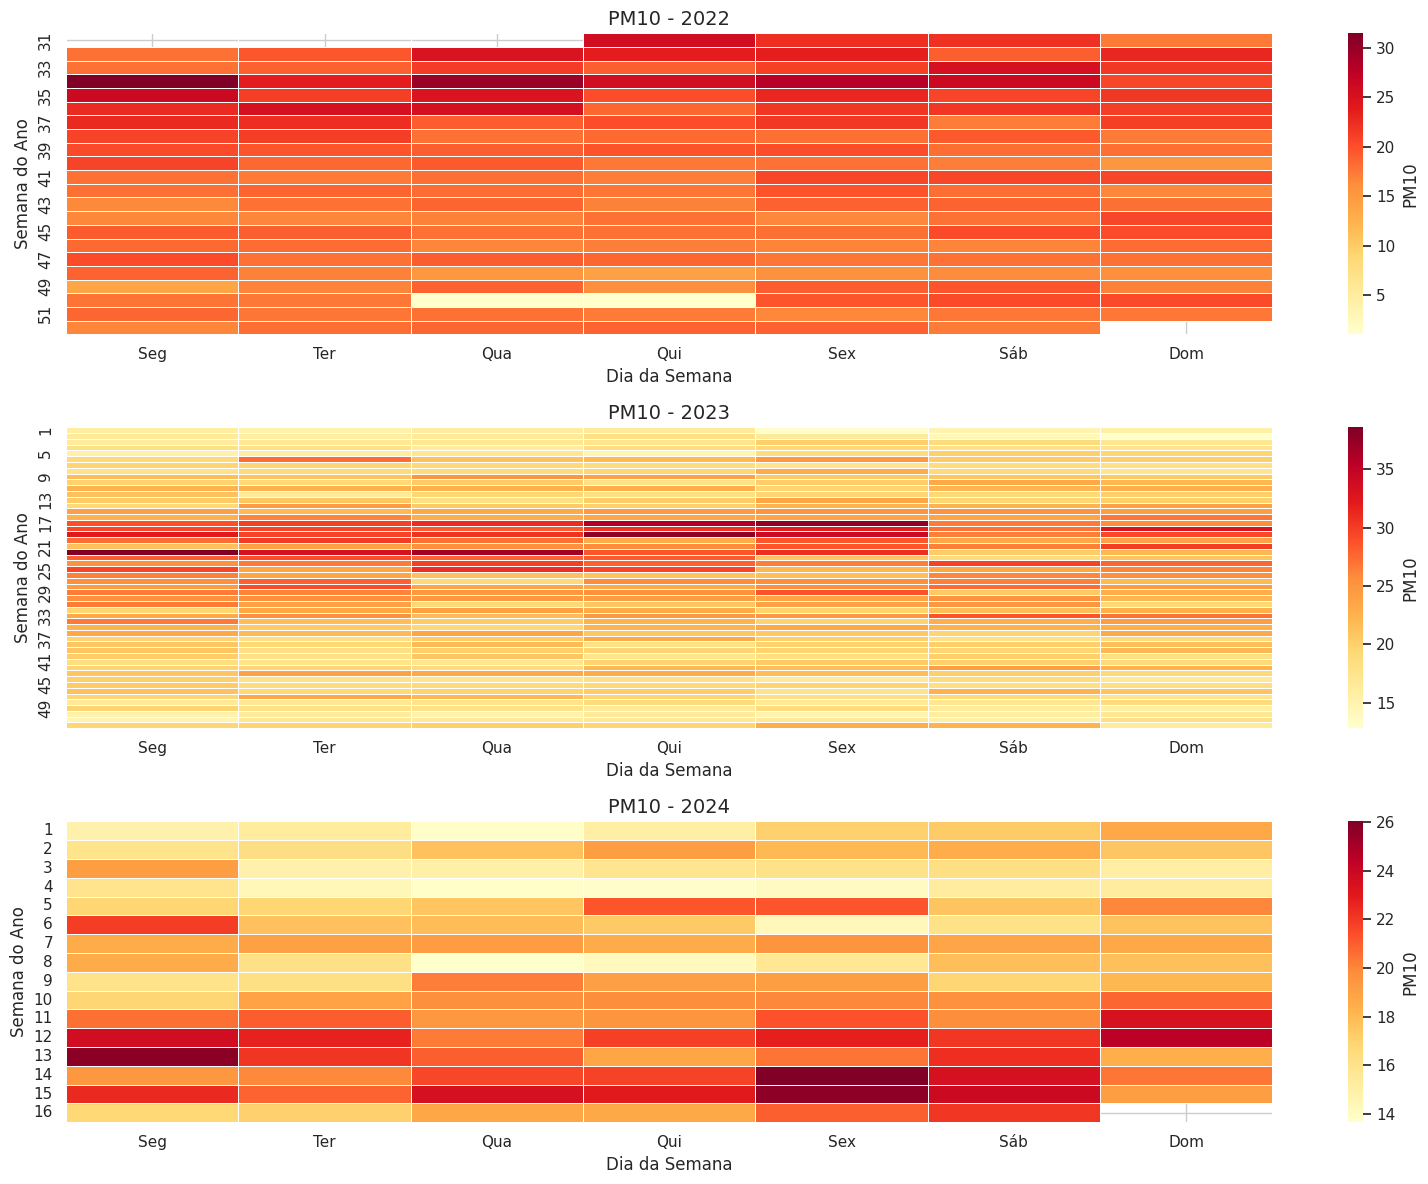

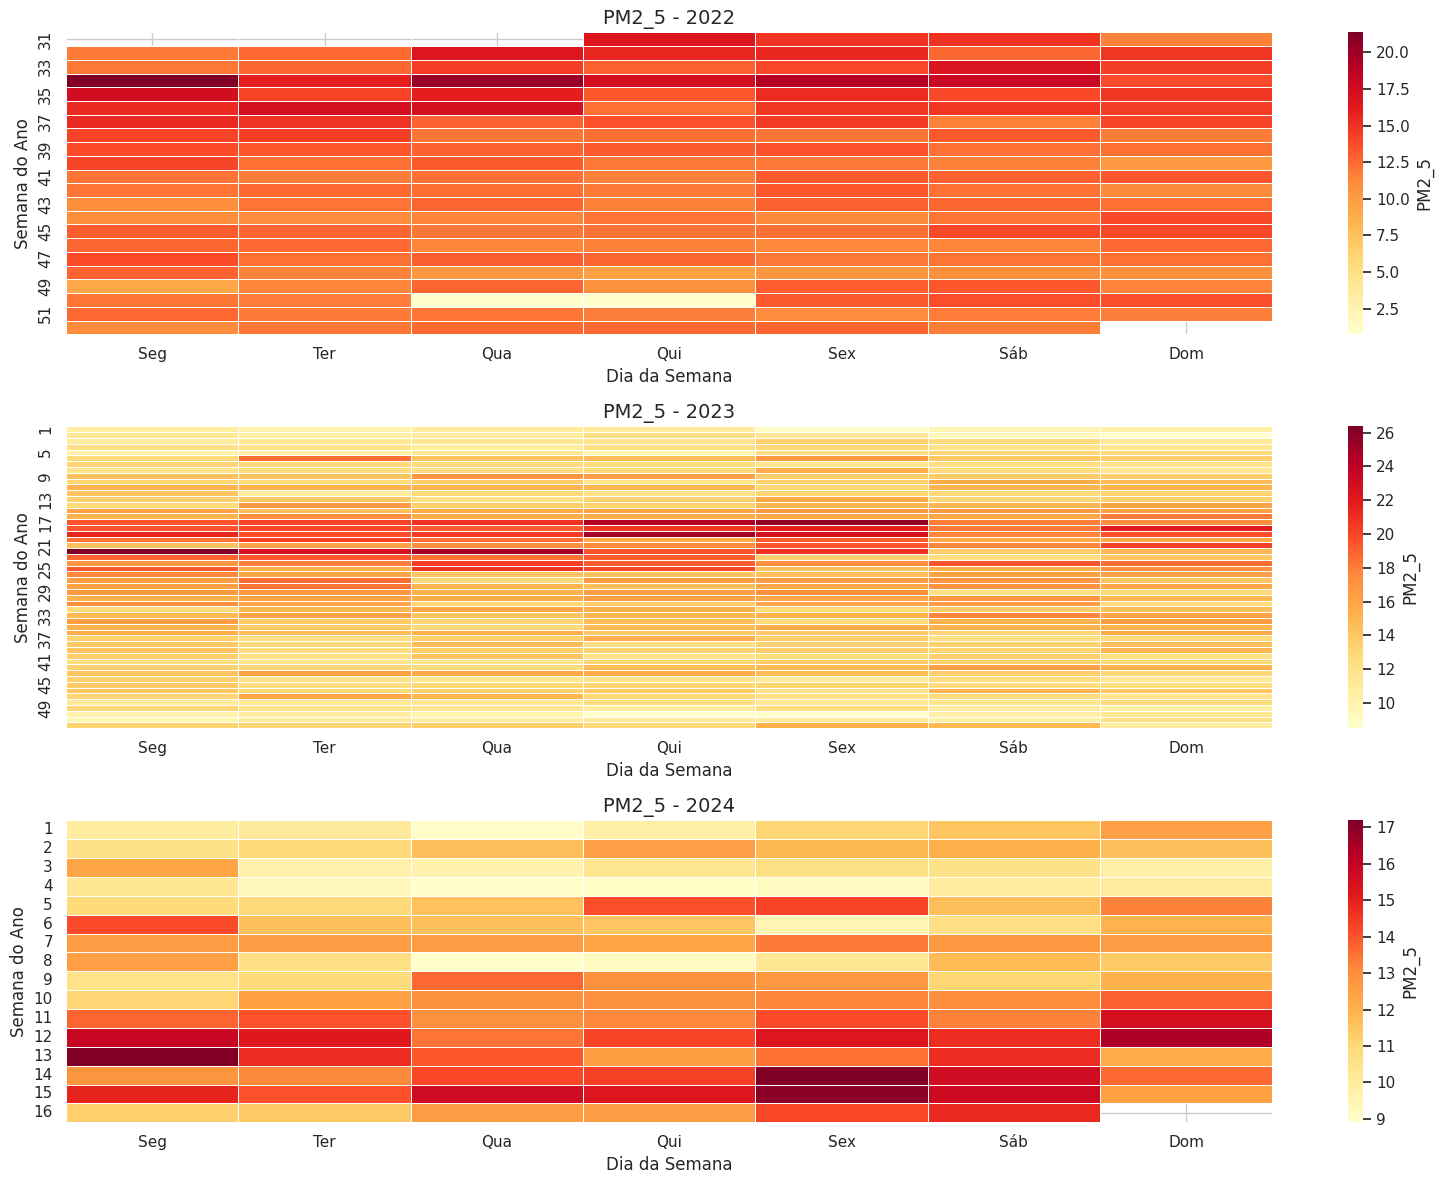

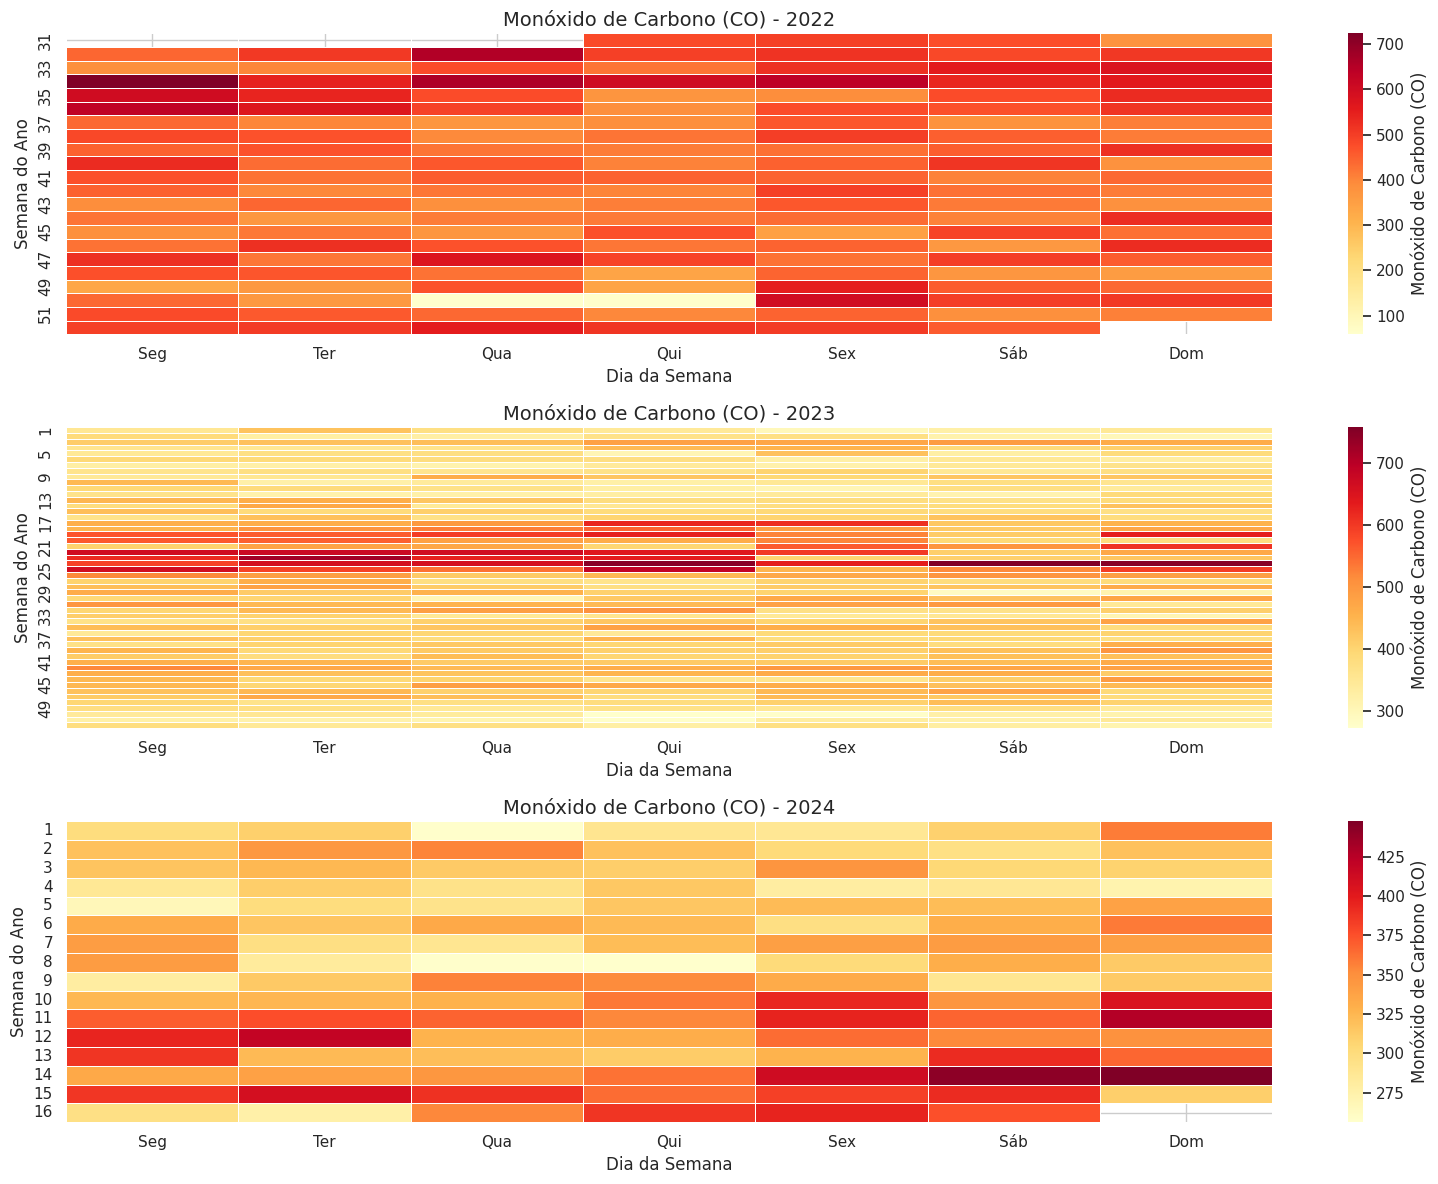

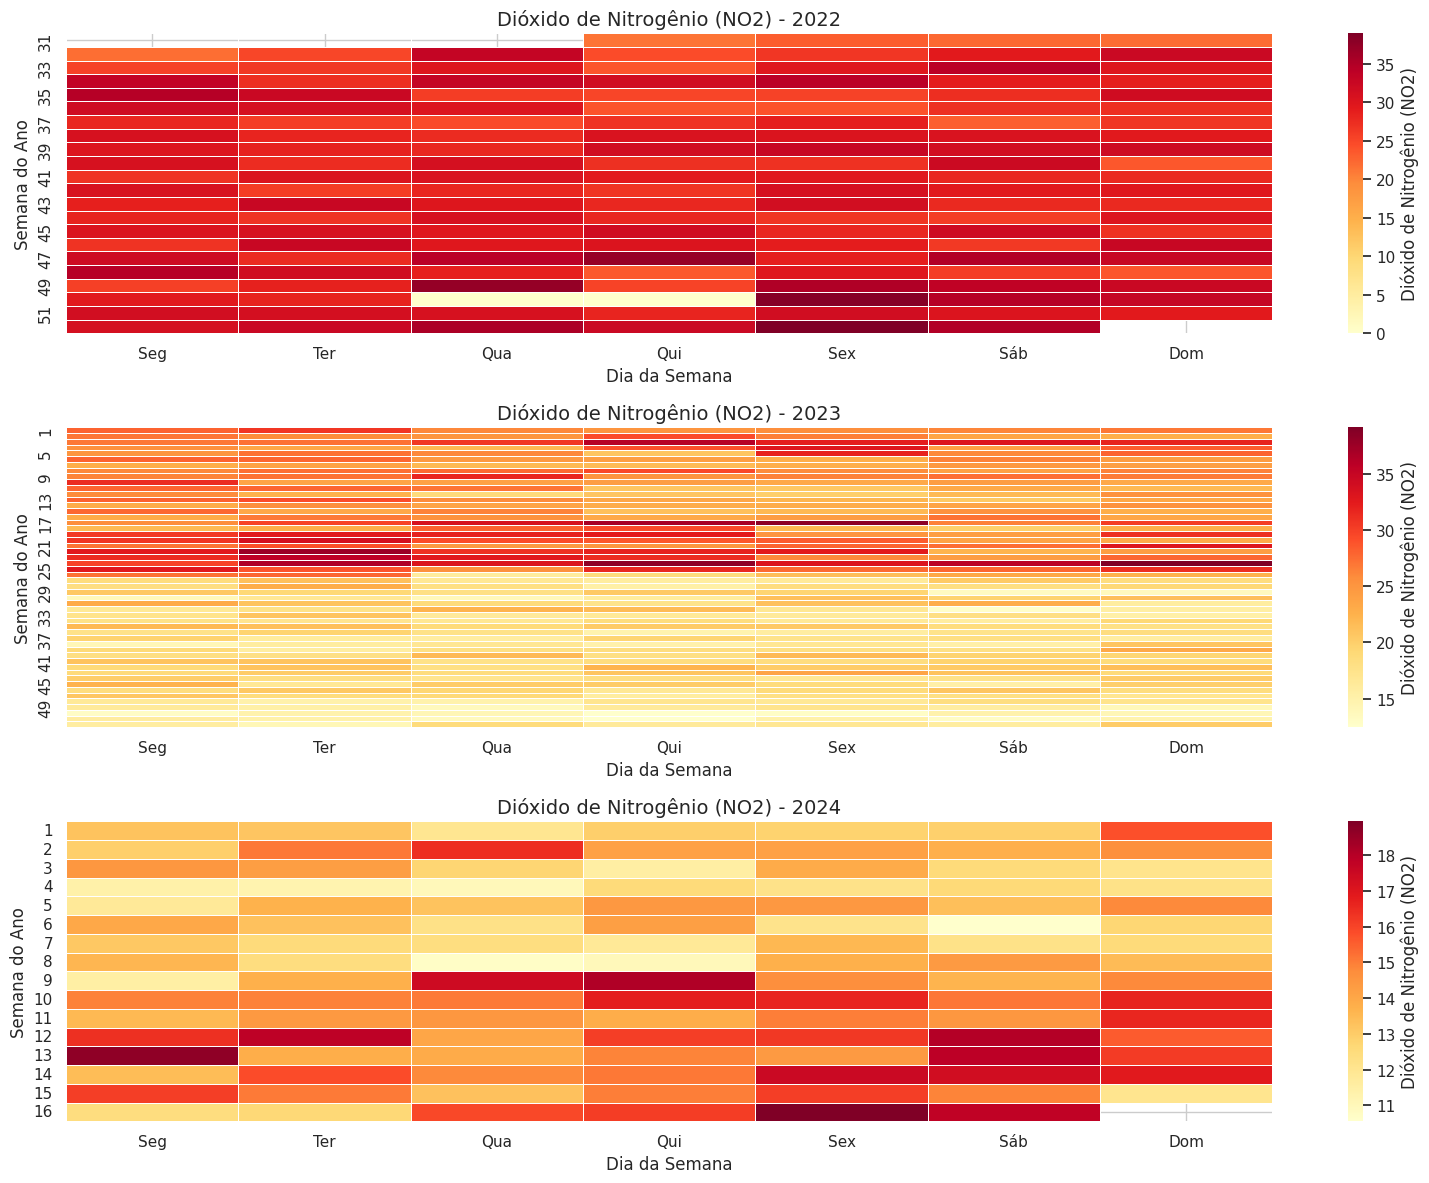

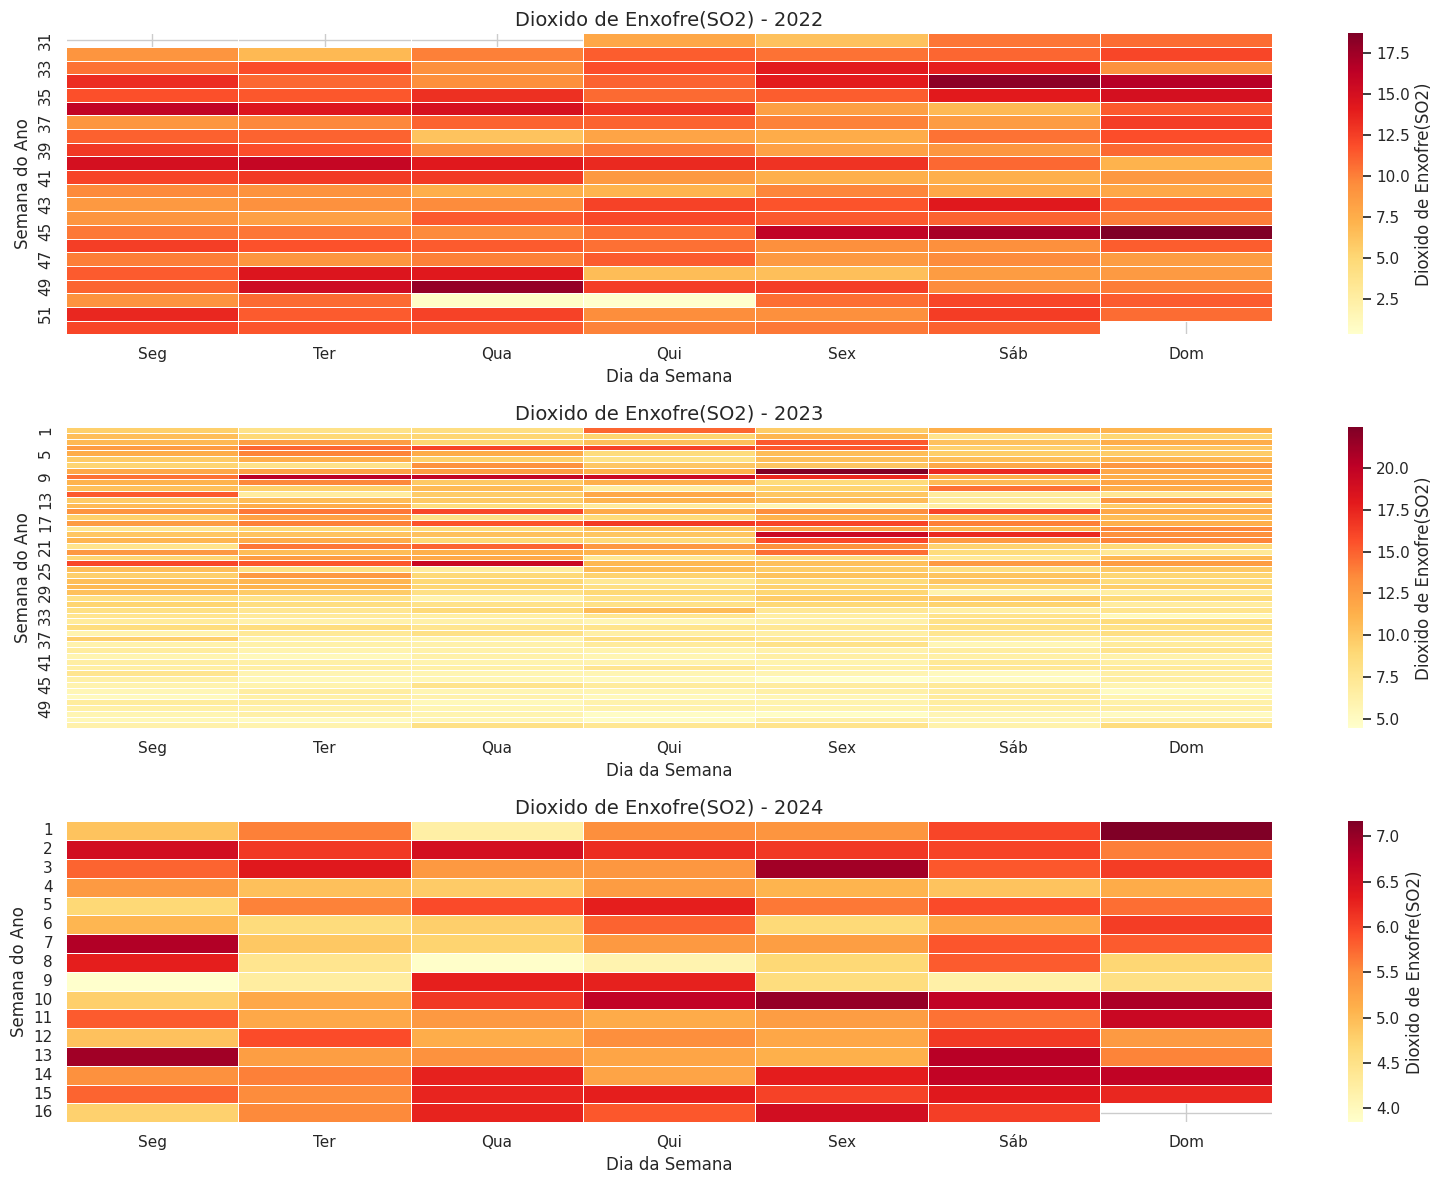

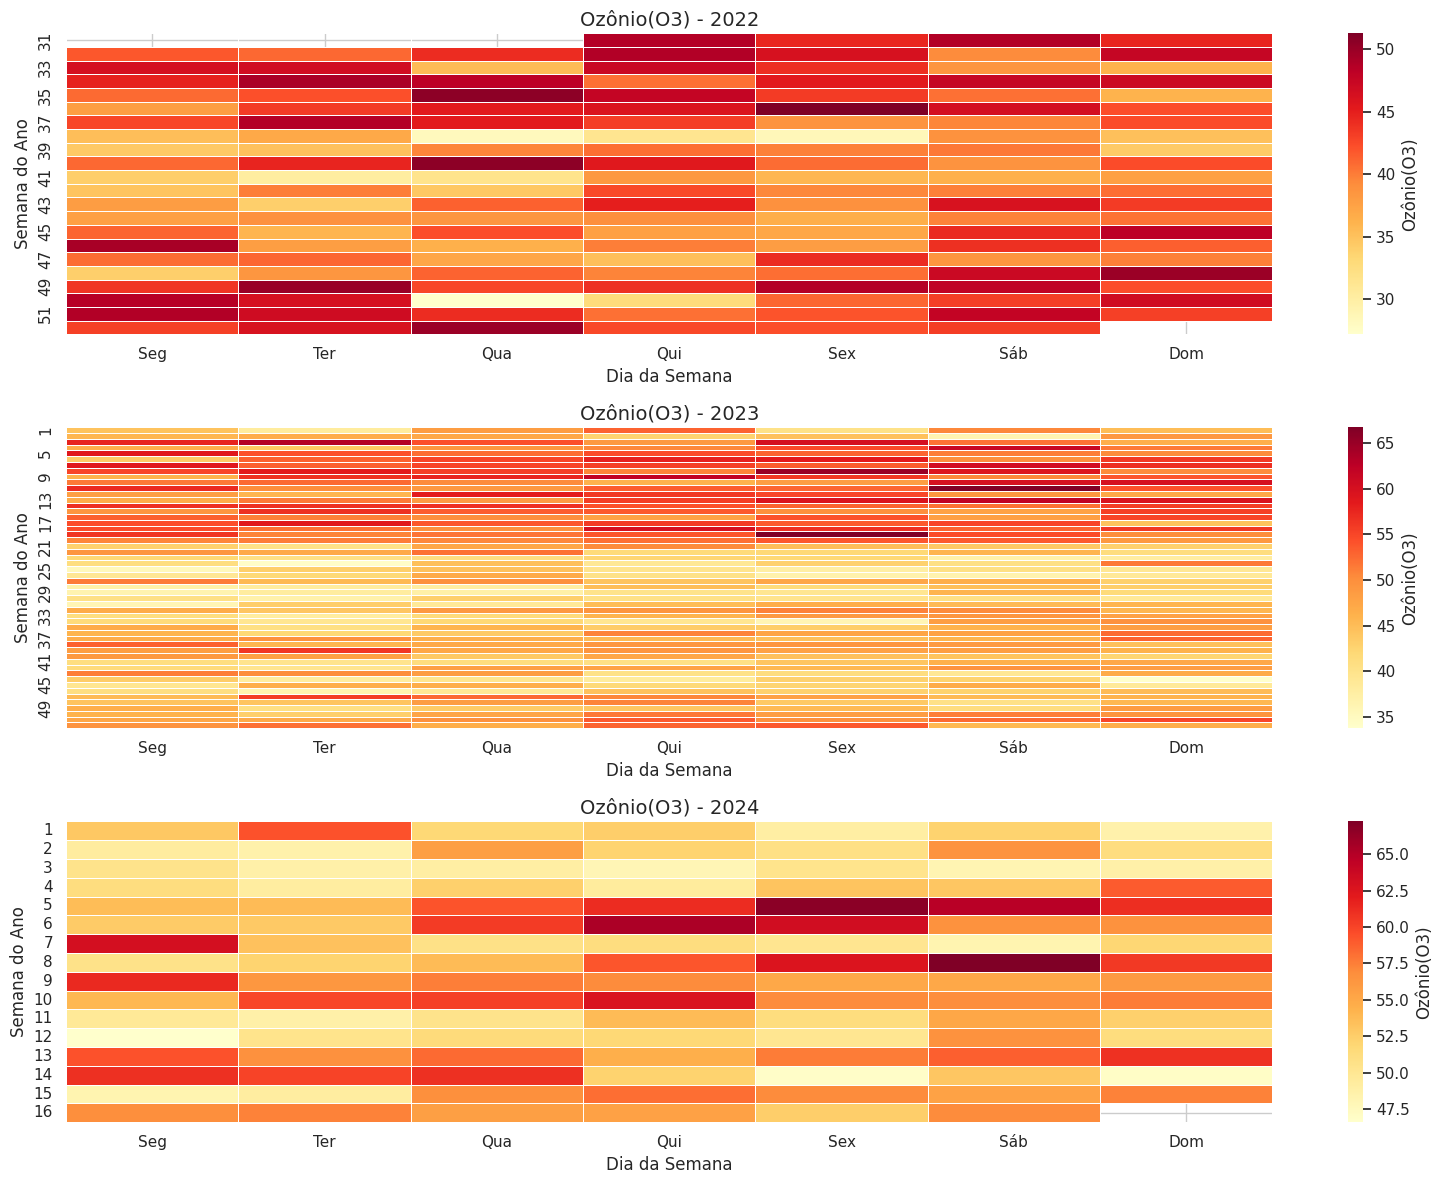

In [ ]:
#Calendar Heatmap por ano da concentração de gases nas capitais da América Latina, exceto Brasília

# --- PRE-PROCESSAMENTO ---
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')
dados_plot = dados_clima.dropna(subset=['Data']).copy()
dados_plot['Ano'] = dados_plot['Data'].dt.year
dados_plot['DiaDoAno'] = dados_plot['Data'].dt.dayofyear

indicadores_poluicao = [
    'PM10', 'PM2_5', 'Monóxido de Carbono (CO)',
    'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)',
    'Ozônio(O3)'
]

anos_disponiveis = [2022, 2023, 2024]

# --- LOOP PARA CADA INDICADOR ---
for indicador in indicadores_poluicao:
    plt.figure(figsize=(16, 4 * len(anos_disponiveis)))

    for i, ano in enumerate(anos_disponiveis):
        df_ano = dados_plot[dados_plot['Ano'] == ano].copy()
        if df_ano.empty:
            continue

        # Criar pivot table: linha = semana do ano, coluna = dia da semana
        df_ano['Semana'] = df_ano['Data'].dt.isocalendar().week
        df_ano['DiaSemana'] = df_ano['Data'].dt.weekday  # 0 = segunda, 6 = domingo
        pivot = df_ano.pivot_table(index='Semana', columns='DiaSemana', values=indicador)

        ax = plt.subplot(len(anos_disponiveis), 1, i + 1)
        sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.5, linecolor='white', cbar_kws={'label': indicador})
        ax.set_title(f"{indicador} - {ano}", fontsize=14)
        ax.set_ylabel("Semana do Ano")
        ax.set_xlabel("Dia da Semana")
        ax.set_xticklabels(['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'])

    plt.tight_layout()
    plt.show()


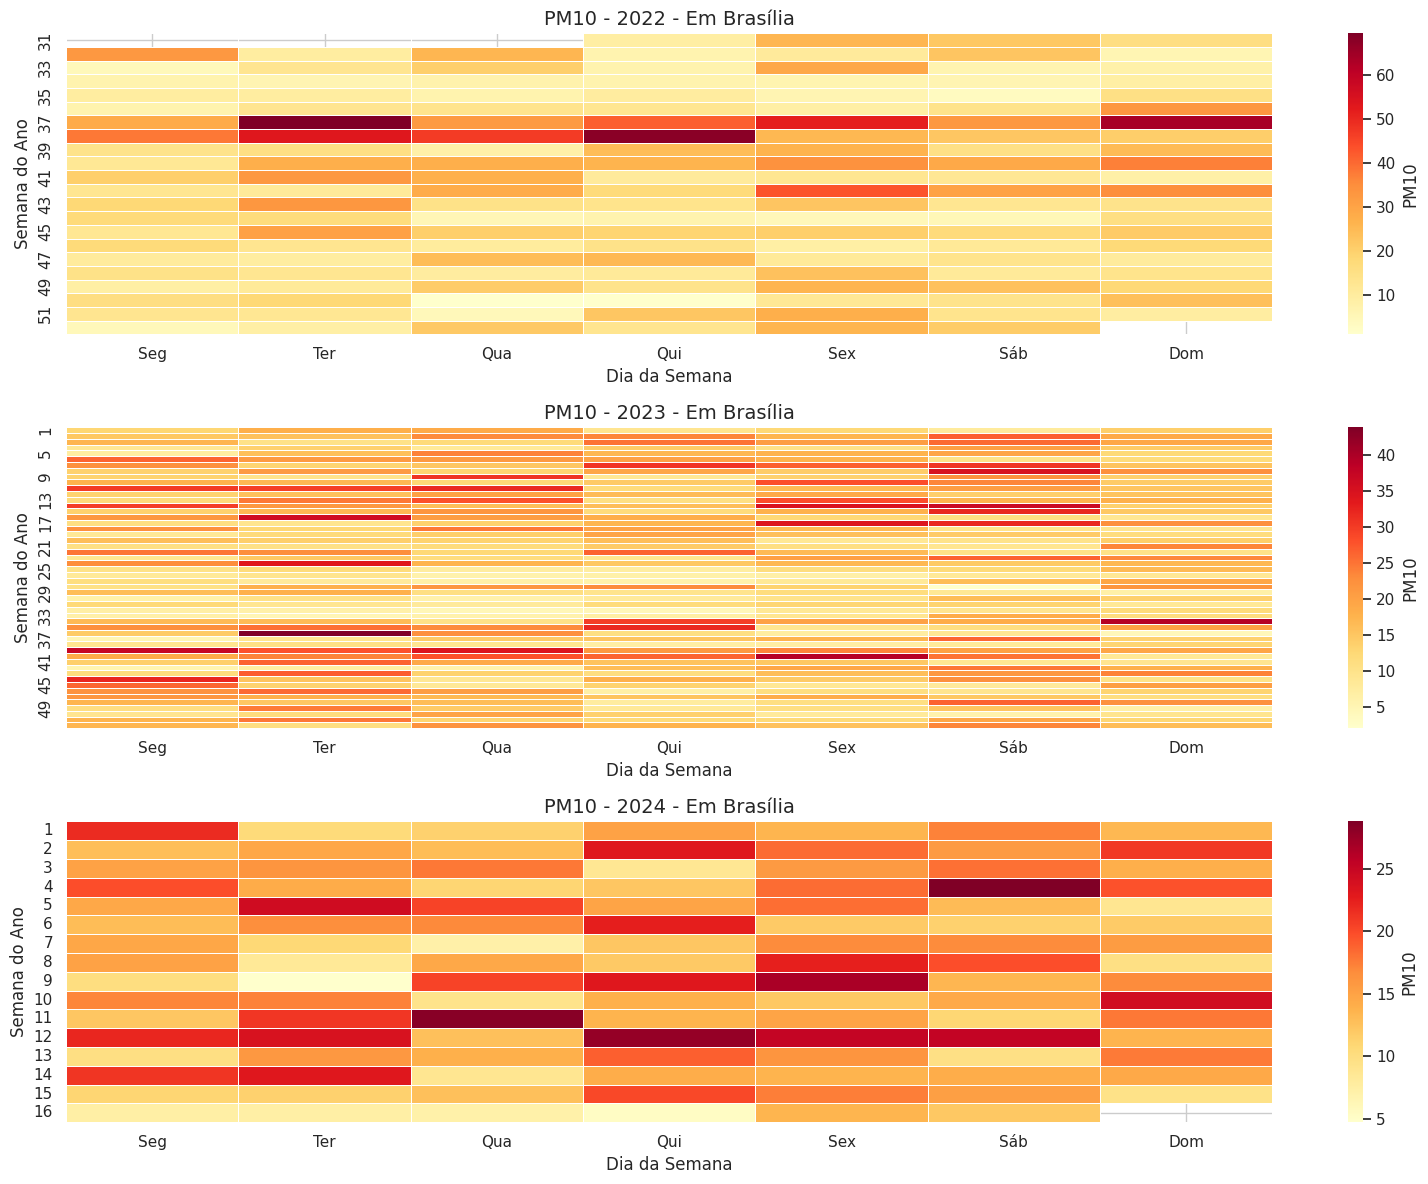

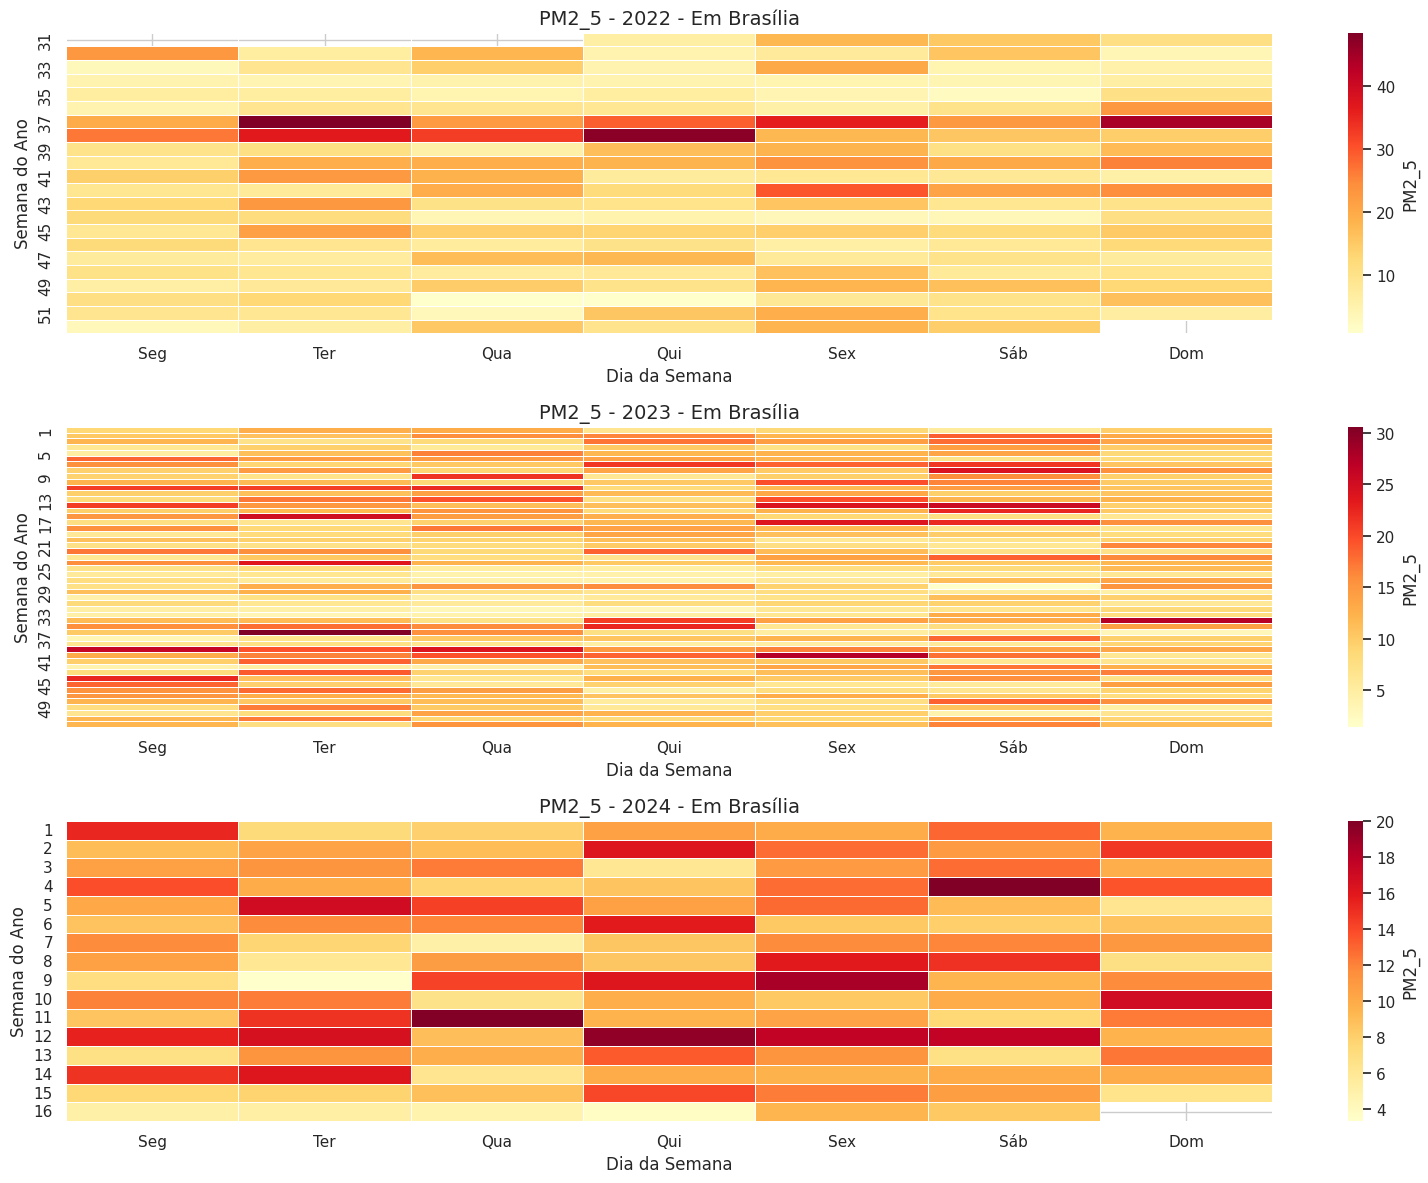

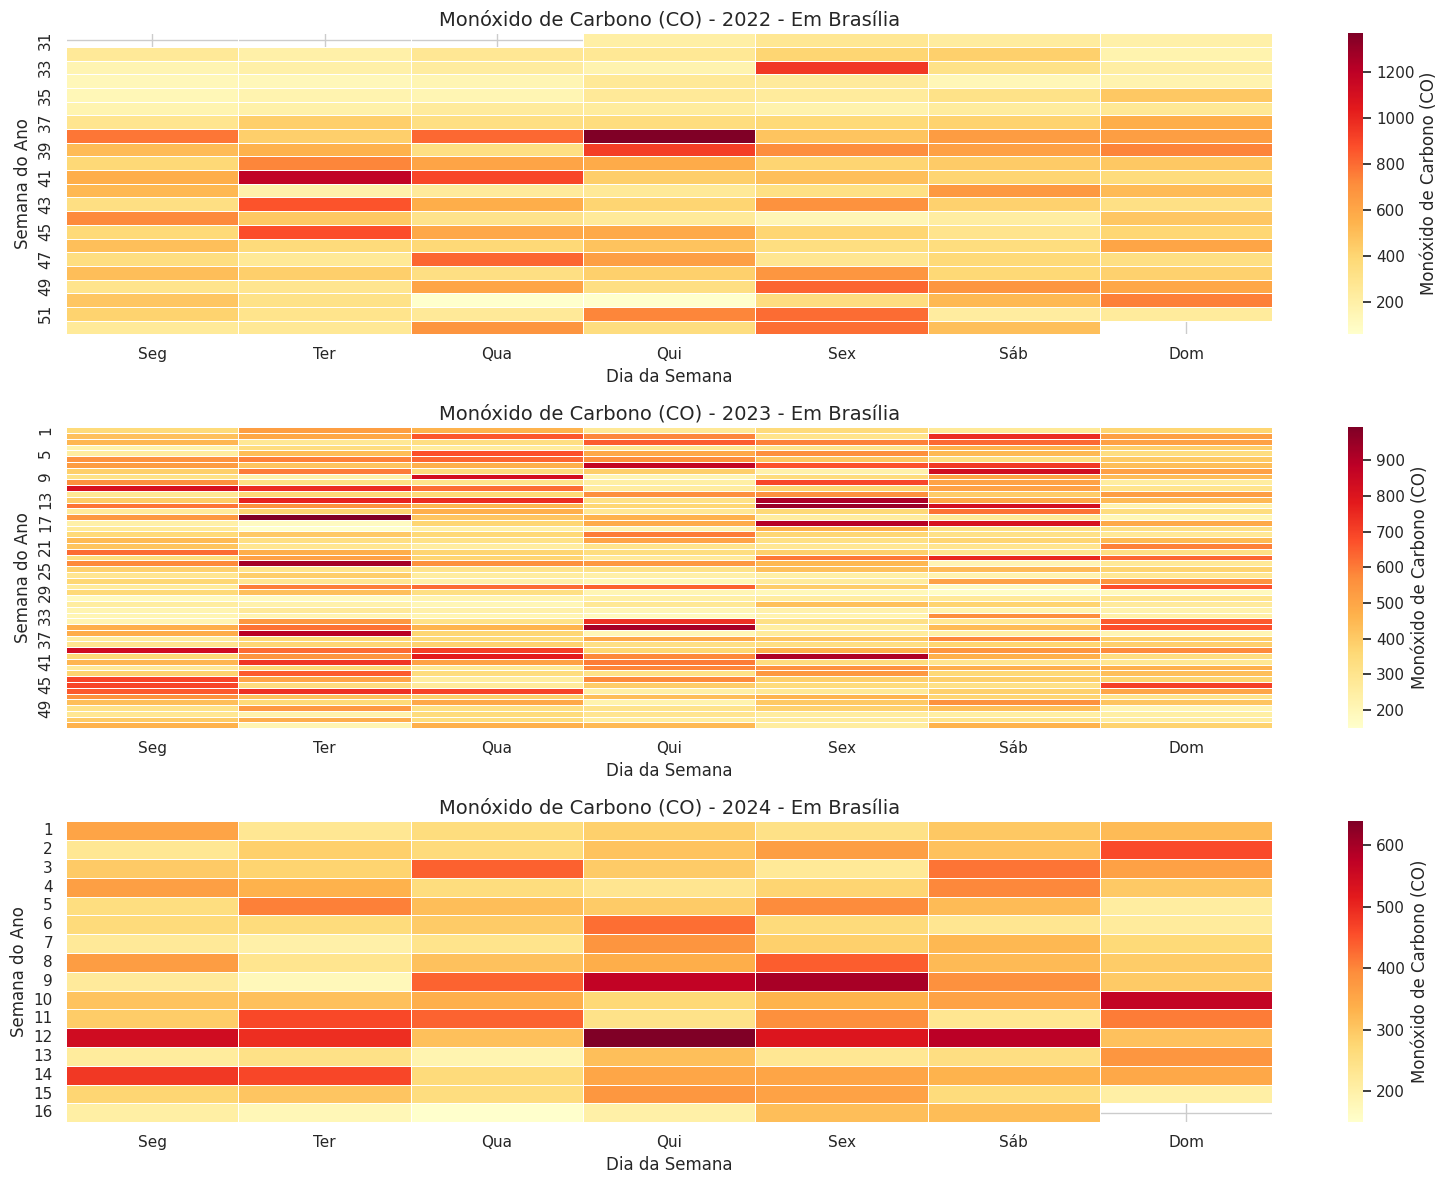

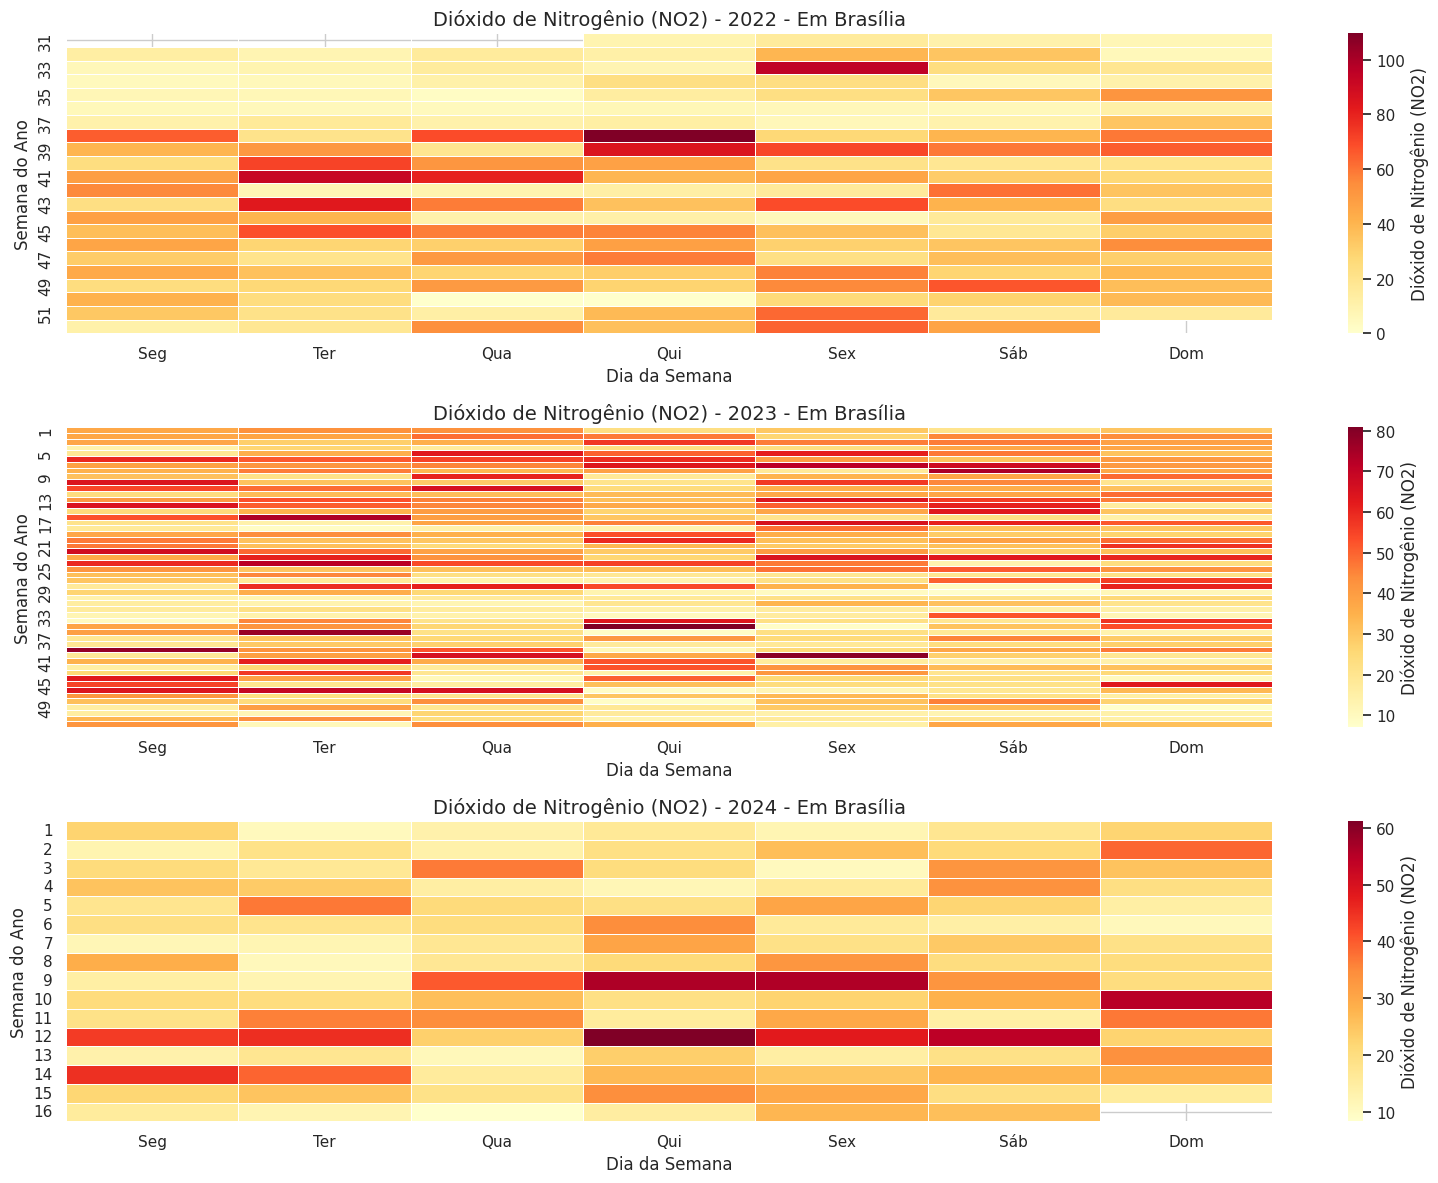

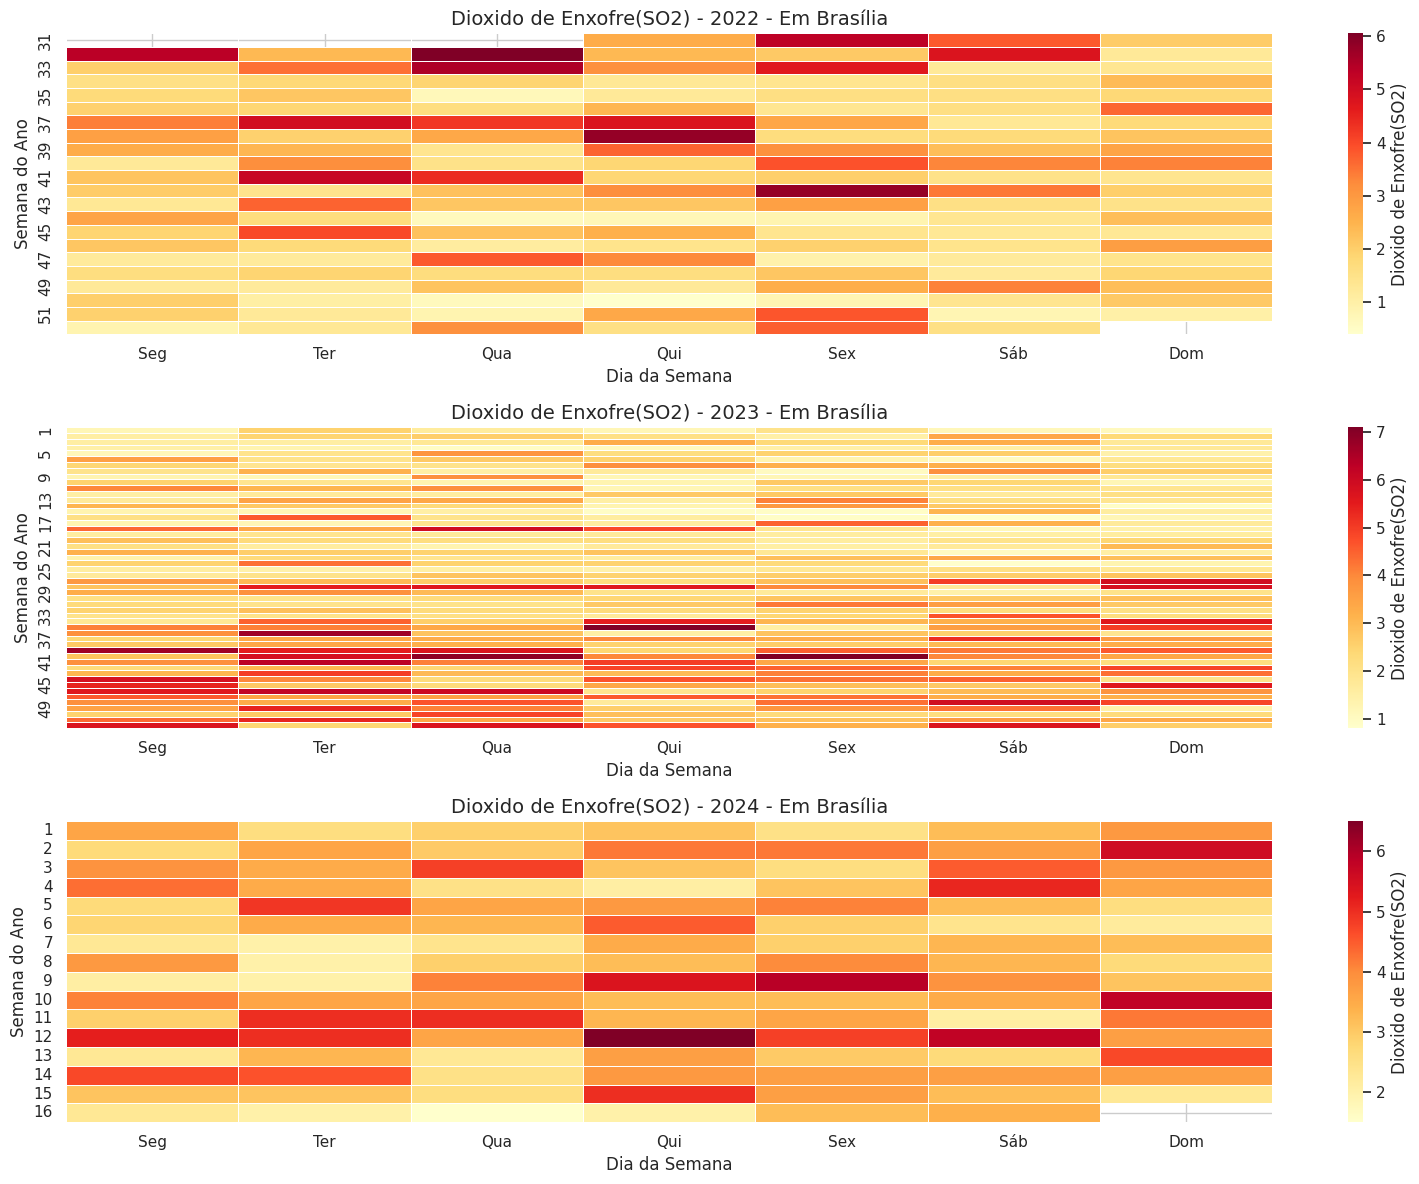

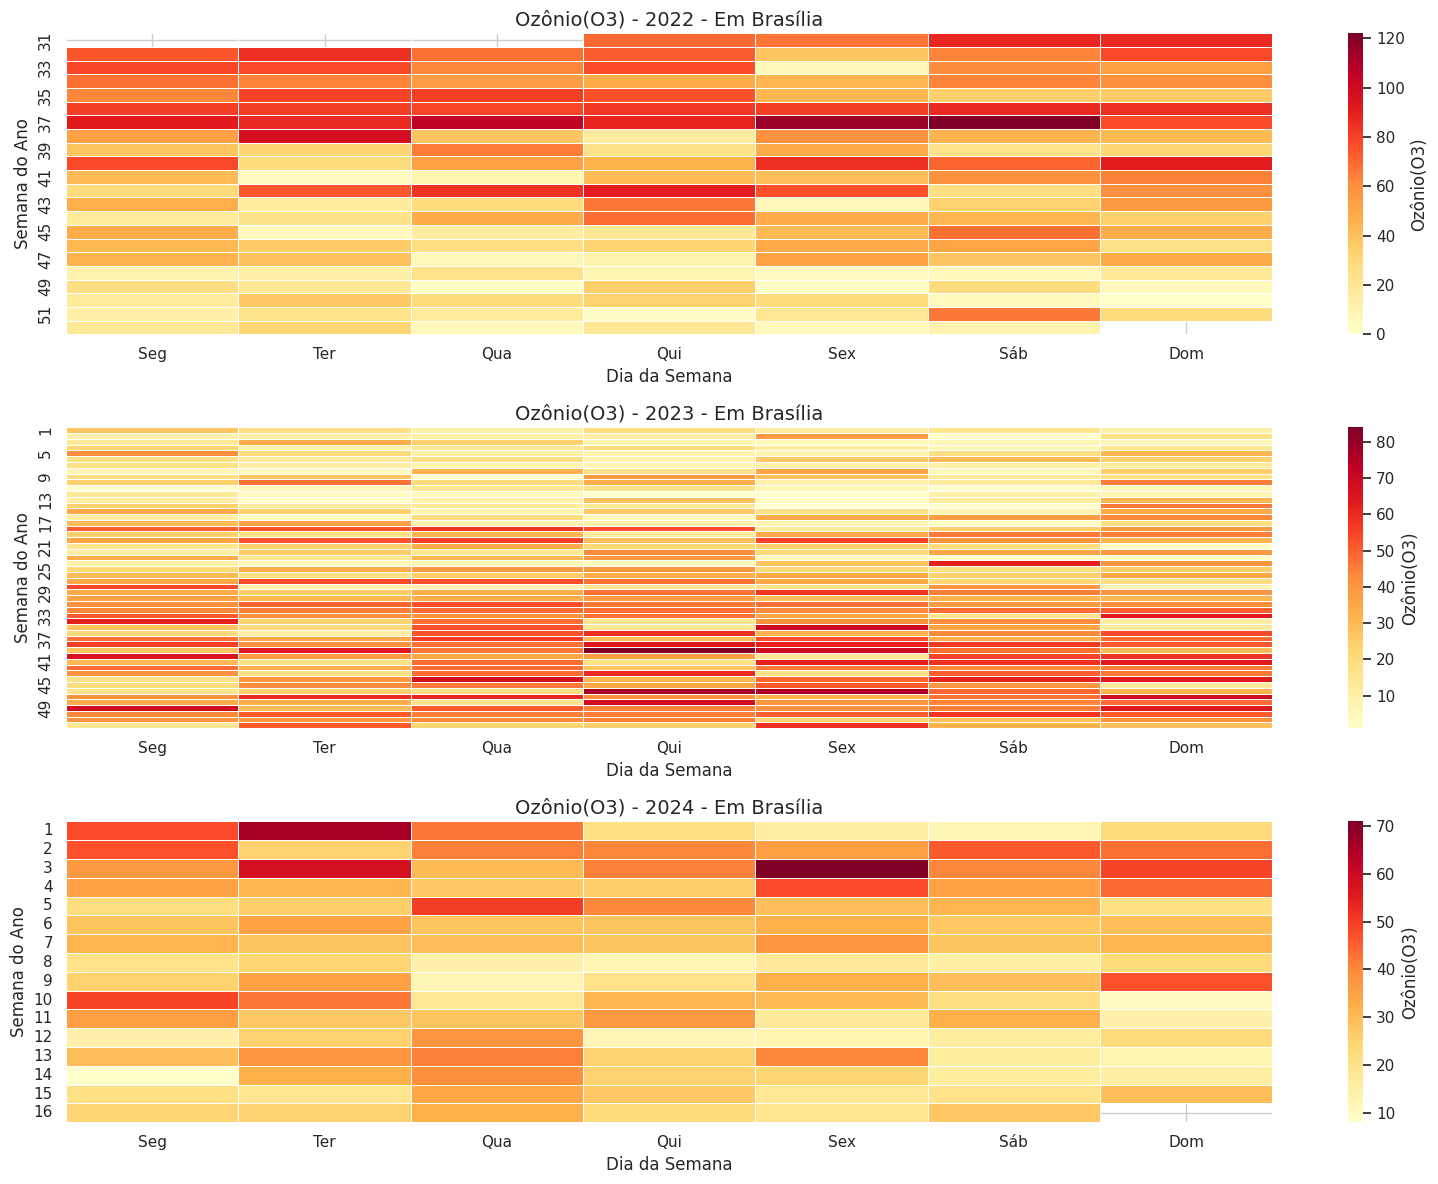

In [ ]:
#Calendar Heatmap por ano da concentração de gases em Brasília

# --- PRE-PROCESSAMENTO ---

dados_plot = (
    dados_clima[dados_clima['Cidade'] == 'Brasília']
    .dropna(subset=['Data'])
    .copy()
)
dados_plot['Ano'] = dados_plot['Data'].dt.year
dados_plot['DiaDoAno'] = dados_plot['Data'].dt.dayofyear

indicadores_poluicao = [
    'PM10', 'PM2_5', 'Monóxido de Carbono (CO)',
    'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)',
    'Ozônio(O3)'
]

anos_disponiveis = [2022, 2023, 2024]

# --- LOOP PARA CADA INDICADOR ---
for indicador in indicadores_poluicao:
    plt.figure(figsize=(16, 4 * len(anos_disponiveis)))

    for i, ano in enumerate(anos_disponiveis):
        df_ano = dados_plot[dados_plot['Ano'] == ano].copy()
        if df_ano.empty:
            continue

        # Criar pivot table: linha = semana do ano, coluna = dia da semana
        df_ano['Semana'] = df_ano['Data'].dt.isocalendar().week
        df_ano['DiaSemana'] = df_ano['Data'].dt.weekday  # 0 = segunda, 6 = domingo
        pivot = df_ano.pivot_table(index='Semana', columns='DiaSemana', values=indicador)

        ax = plt.subplot(len(anos_disponiveis), 1, i + 1)
        sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.5, linecolor='white', cbar_kws={'label': indicador})
        ax.set_title(f"{indicador} - {ano} - Em Brasília", fontsize=14)
        ax.set_ylabel("Semana do Ano")
        ax.set_xlabel("Dia da Semana")
        ax.set_xticklabels(['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'])

    plt.tight_layout()
    plt.show()


De forma geral, a análise mostra que as maiores concentrações de poluentes ocorreram no mês de maio, indicando um possível aumento das emissões ou condições climáticas menos favoráveis à dispersão nesse período. Já em Brasília, o pico de concentração foi observado em setembro, mês que coincide com a estação seca no Centro-Oeste, caracterizada por baixos níveis de umidade, maior ocorrência de queimadas e menor ventilação, fatores que favorecem o acúmulo de poluentes na atmosfera.

4- Describe geral da tabela, mostrando os dados que temos e algumas caracteristicas gerais deles

In [ ]:
dados_clima.describe()

Latitude     Longitude          PM10         PM2_5  \
count  12640.000000  12640.000000  12520.000000  12520.000000   
mean      -0.351840    -74.647240     20.669625     13.758530   
std       19.473623     12.946283     16.881122     11.665622   
min      -34.901100    -99.133200      0.300000      0.200000   
25%      -16.624925    -84.627075     11.400000      7.500000   
50%        9.455250    -75.557450     17.100000     11.200000   
75%       14.212950    -66.493175     24.700000     16.500000   
max       23.113600    -47.921800    292.400000    204.900000   

       Monóxido de Carbono (CO2)  Dióxido de Nitrogênio (NO2)  \
count               12520.000000                 12520.000000   
mean                  414.904233                    22.484069   
std                   496.742344                    24.845234   
min                    58.000000                     0.000000   
25%                   181.000000                     6.700000   
50%                   263.000000                    15.100000   
75%                   444.000000                    30.900000   
max                  7635.000000                   324.400000   

       Dioxido de Enxofre(SO2)    Ozônio(O3)  
count             12520.000000  12520.000000  
mean                  8.930359     47.499201  
std                  13.674541     32.397686  
min                   0.000000      0.000000  
25%                   1.700000     26.000000  
50%                   4.100000     42.000000  
75%                  10.200000     62.000000  
max                 166.200000    332.000000

5- visualização geral dos indices, com mapa interativo da seria temporal mostrando a evolução da temp, da evapotranspiração e do vento

tentar juntar isso com uma visualização geral das variaveis

6- estruturar uma ideia pra medir a qualidade do ar

✅ Indicadores a serem analisados: ['PM10', 'PM2_5', 'Dióxido de Nitrogênio (NO2)', 'Ozônio(O3)', 'Monóxido de Carbono (CO)', 'Dioxido de Enxofre(SO2)']


/tmp/ipython-input-198335559.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



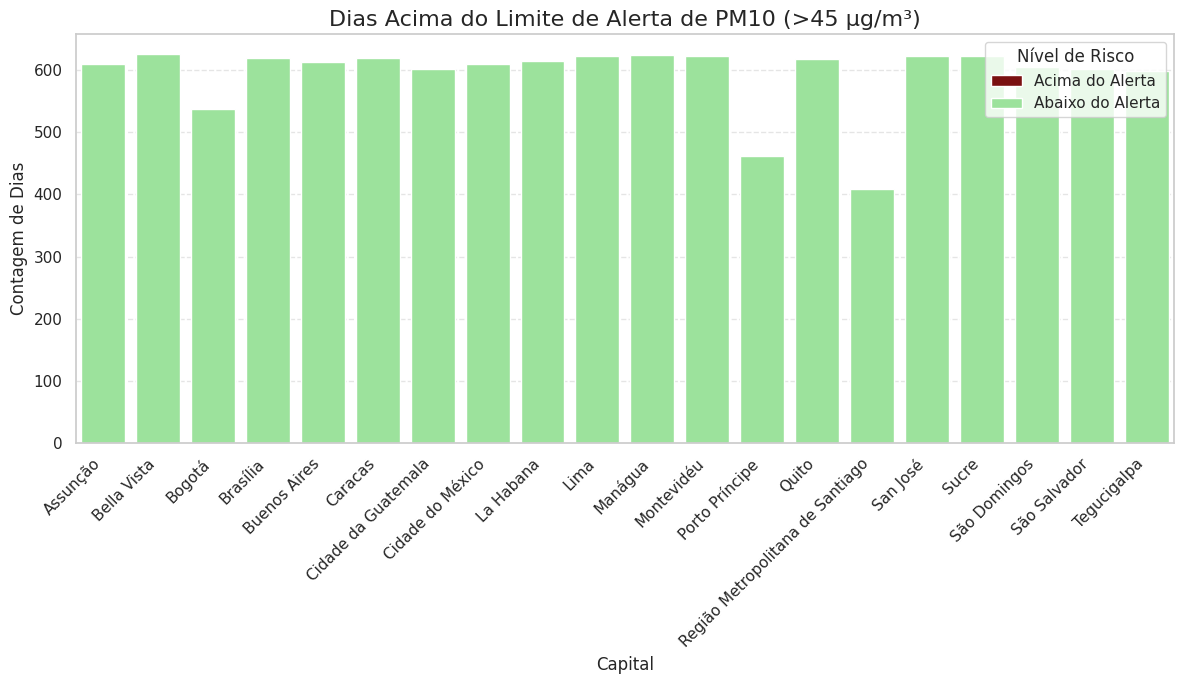

/tmp/ipython-input-198335559.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



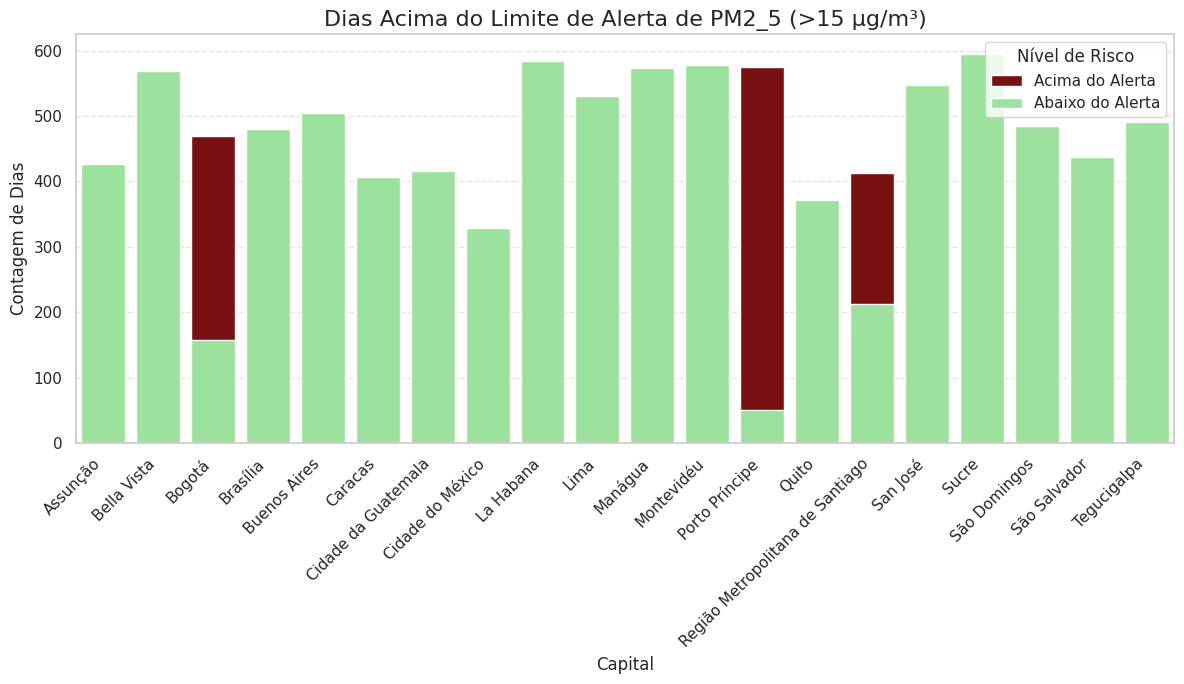

/tmp/ipython-input-198335559.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



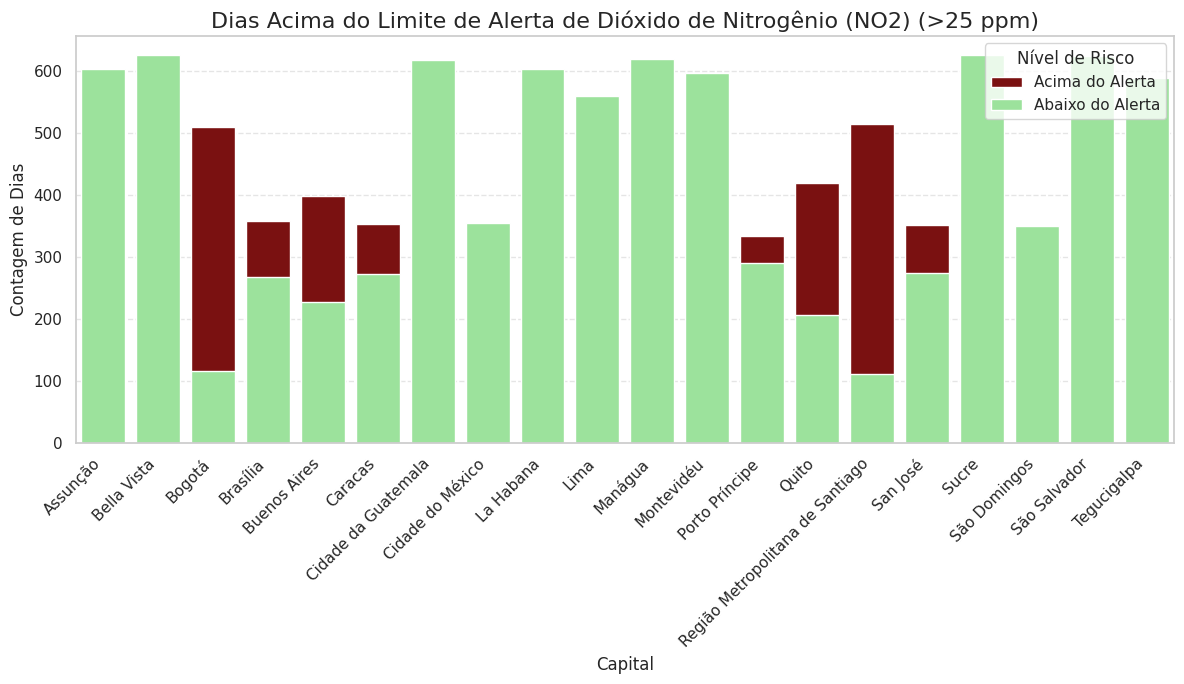

/tmp/ipython-input-198335559.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



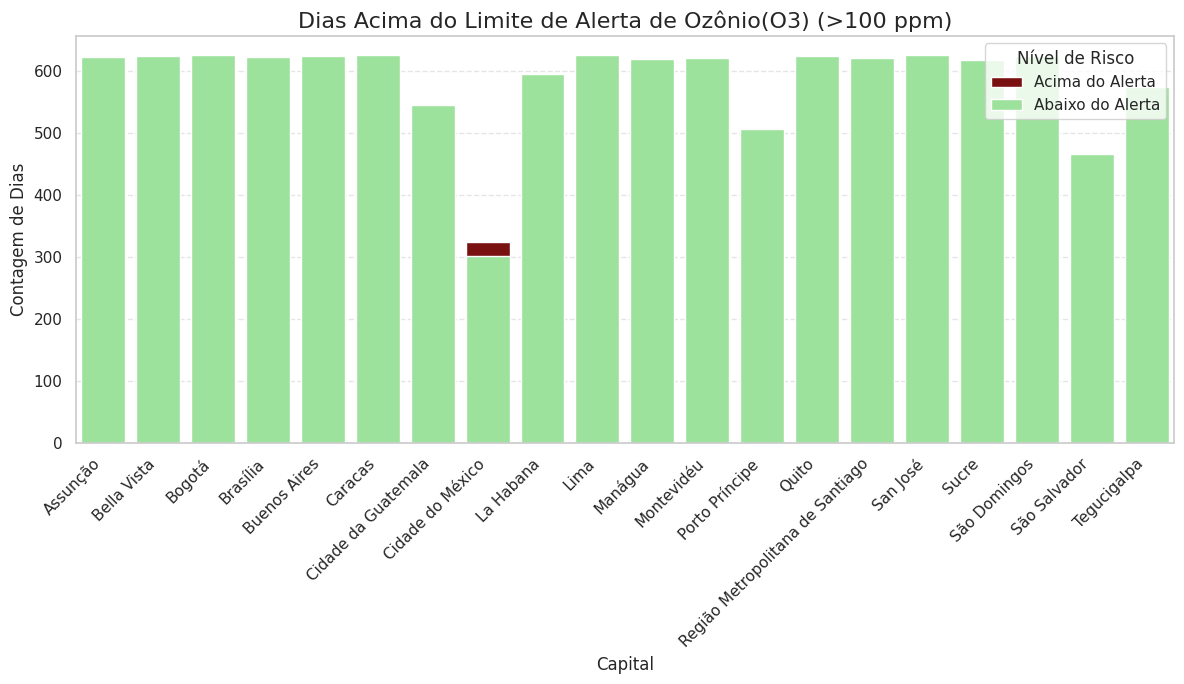

/tmp/ipython-input-198335559.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



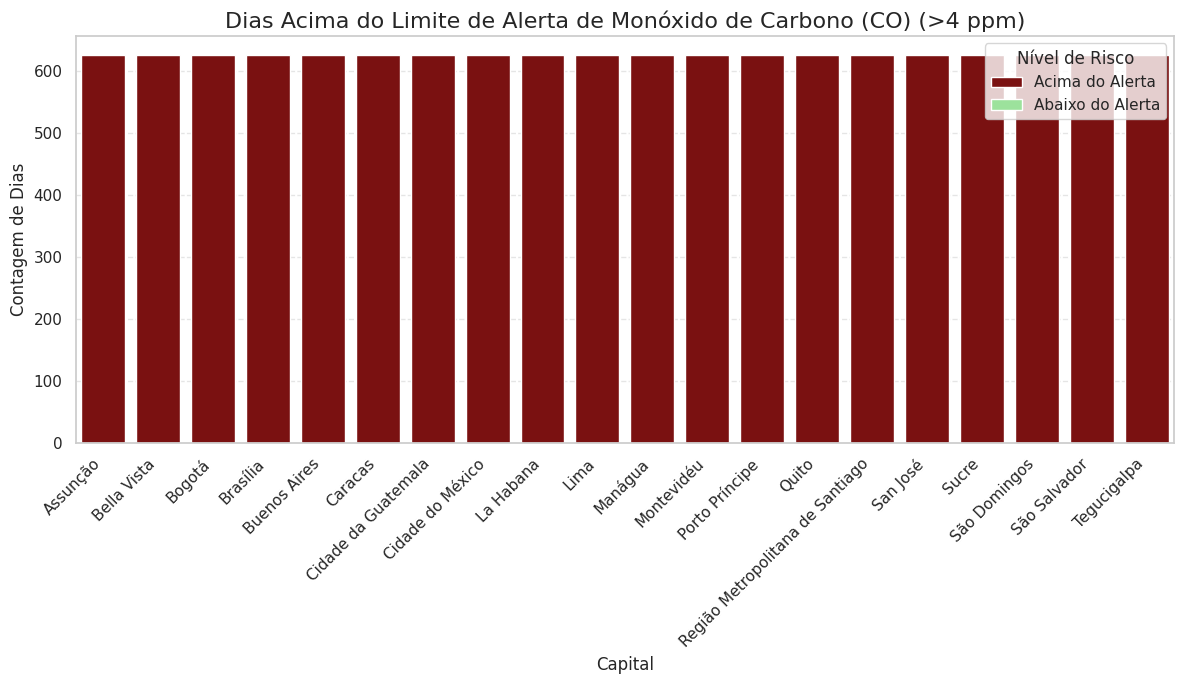

/tmp/ipython-input-198335559.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



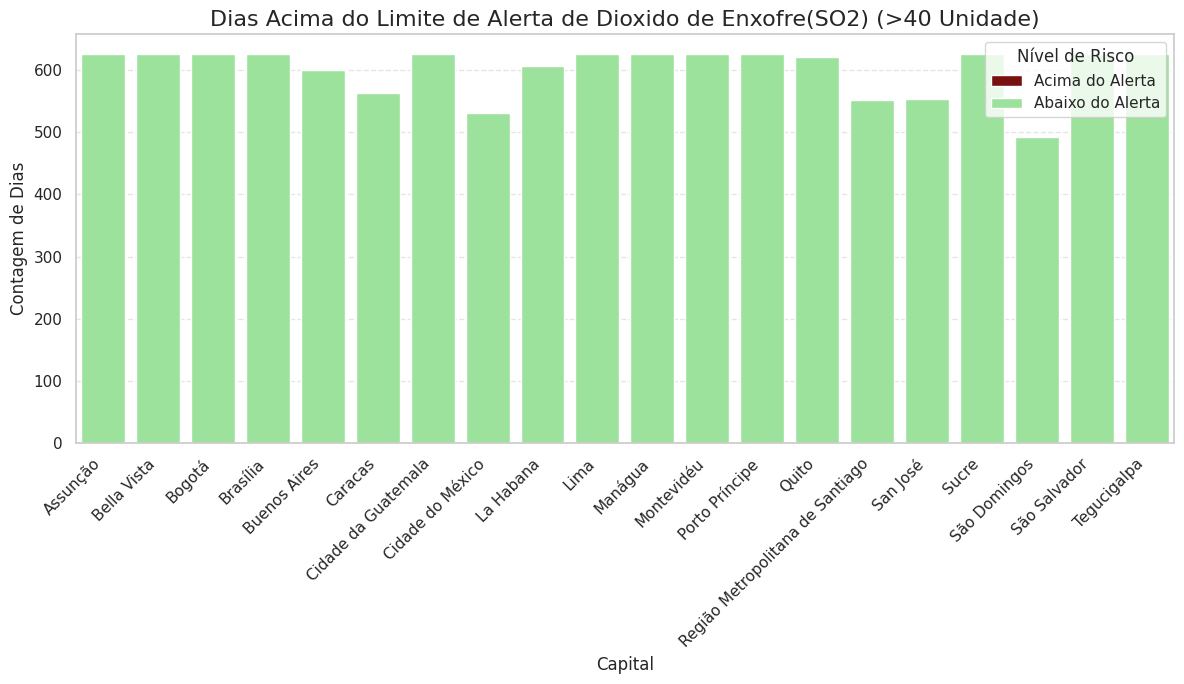

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. PREPARAÇÃO E DEFINIÇÃO DE LIMITES ---

# 1. Garantir que a coluna 'Data' seja do tipo datetime (manter)
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')
df_eventos_base = dados_clima.dropna(subset=['Cidade']).copy()

# 2. DEFINIÇÃO DE LIMITES DE ALERTA (Ajuste estes valores conforme a norma desejada)
# Assumimos limites diários ou de 24h, exceto para CO (que geralmente é 8h)
limites_alerta = {
    'PM10': 45,    # μg/m³
    'PM2_5': 15,   # μg/m³
    'Dióxido de Nitrogênio (NO2)': 25,    # μg/m³
    'Ozônio(O3)': 100,     # μg/m³
    'Monóxido de Carbono (CO)': 4,       # ppm
    'Dioxido de Enxofre(SO2)': 40      # μg/m³
}

# Filtra a lista para incluir SOMENTE as colunas que realmente existem no DataFrame
colunas_disponiveis = df_eventos_base.columns.tolist()
indicadores_poluicao = [ind for ind in limites_alerta.keys() if ind in colunas_disponiveis]

# Dicionário de unidades (para o título)
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO)': 'ppm',
    'Dióxido de Enxofre(SO2)':'ppm'
}

print(f"✅ Indicadores a serem analisados: {indicadores_poluicao}")

# --- 3. FUNÇÃO PARA GERAR O GRÁFICO DE BARRAS EMPILHADAS ---

def plot_contagem_de_eventos(df_base, indicador, limite, unidade):

    # Remove NaN para as colunas necessárias para o plot
    df_plot = df_base.dropna(subset=[indicador, 'Cidade']).copy()

    if df_plot.empty:
        print(f"Aviso: Dados insuficientes para plotar {indicador}.")
        return

    # CLASSIFICAÇÃO POR CATEGORIA DE RISCO
    df_plot['Risco'] = pd.cut(
        df_plot[indicador],
        bins=[-float('inf'), limite, float('inf')],
        labels=['Abaixo do Alerta', 'Acima do Alerta'],
        right=False
    )

    # AGRUPAMENTO E CONTAGEM
    df_contagem = df_plot.groupby(['Cidade', 'Risco']).size().reset_index(name='Contagem_Dias')

    # Garantir a ordem das categorias (importante para o empilhamento)
    df_contagem['Risco'] = pd.Categorical(
        df_contagem['Risco'],
        categories=['Abaixo do Alerta', 'Acima do Alerta'],
        ordered=True
    )

    # --- GERAÇÃO DO PLOT ---
    plt.figure(figsize=(12, 7))

    sns.barplot(
        data=df_contagem,
        x='Cidade',
        y='Contagem_Dias',
        hue='Risco',
        hue_order=['Acima do Alerta', 'Abaixo do Alerta'], # O mais crítico primeiro
        dodge=False, # Essencial para empilhar
        palette={'Acima do Alerta': 'darkred', 'Abaixo do Alerta': 'lightgreen'}
    )

    # AJUSTES FINAIS DO LAYOUT
    unidade_str = unidade.get(indicador, 'Unidade')
    titulo = f'Dias Acima do Limite de Alerta de {indicador} (>{limite} {unidade_str})'

    plt.title(titulo, fontsize=16)
    plt.xlabel('Capital', fontsize=12)
    plt.ylabel('Contagem de Dias', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Nível de Risco', loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# --- 4. EXECUÇÃO DO LOOP PARA TODOS OS INDICADORES ---

for indicador in indicadores_poluicao:
    limite = limites_alerta[indicador]
    plot_contagem_de_eventos(df_eventos_base, indicador, limite, unidades)

##**Intervalo de Confiança**



1- A média dos níveis de poluição em Brasília difere de forma estatisticamente significativa da média das outras capitais da América Latina?


Antes de executar um Teste de Hipóteses, vamos fazer uma comparação e análise visual envolvendo Intervalos de Confiança.

In [ ]:
indicadores_poluicao = [
    'PM10', 'PM2_5', 'Monóxido de Carbono (CO)',
    'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)',
    'Ozônio(O3)'
]
media_cidades = dados_clima[indicadores_poluicao + ['Cidade']].groupby('Cidade').mean().reset_index()

In [ ]:
media_cidades

Cidade       PM10      PM2_5  \
0                           Assunção  18.810703  13.113898   
1                        Bella Vista  15.604633   9.694249   
2                             Bogotá  30.747444  21.546326   
3                           Brasília  16.501438  11.519010   
4                       Buenos Aires  15.860383  10.664696   
5                            Caracas  19.557508  13.438818   
6                Cidade da Guatemala  20.723802  14.196326   
7                   Cidade do México  22.703035  15.520447   
8                          La Habana  16.501757   9.255112   
9                               Lima  20.578754  12.510224   
10                           Manágua  12.718850   8.452556   
11                        Montevidéu  12.592332   7.867891   
12                    Porto Príncipe  38.731789  25.865815   
13                             Quito  20.107348  14.038339   
14  Região Metropolitana de Santiago  49.691214  34.292013   
15                          San José  13.804153   9.496645   
16                             Sucre   8.583706   5.944409   
17                      São Domingos  21.355911  12.419808   
18                      São Salvador  20.894888  13.578594   
19                       Tegucigalpa  17.322843  11.755431   

    Monóxido de Carbono (CO)  Dióxido de Nitrogênio (NO2)  \
0                 336.381789                     8.830911   
1                 202.400958                     8.472045   
2                 897.638978                    37.555751   
3                 402.910543                    31.909824   
4                 388.857827                    34.535863   
5                 499.789137                    29.704233   
6                 304.244409                     8.562780   
7                 451.060703                    27.372684   
8                 155.889776                     8.576677   
9                 179.531949                    19.921326   
10                166.939297                     5.182668   
11                166.249201                     8.429153   
12               1213.397764                    50.661422   
13                488.404153                    30.886741   
14               1207.712460                    62.557348   
15                308.413738                    27.317572   
16                199.884984                     3.946246   
17                197.474441                    27.173562   
18                260.966454                     7.384665   
19                269.936102                    10.699920   

    Dioxido de Enxofre(SO2)  Ozônio(O3)  
0                  0.667173   42.722045  
1                  4.135543   54.314696  
2                  9.121885   20.544728  
3                  2.828275   34.373802  
4                 14.000559   21.153355  
5                 17.062141   21.712460  
6                  2.169249   66.006390  
7                 23.056150  109.525559  
8                 11.410304   66.364217  
9                  6.781070   33.984026  
10                 3.017173   50.872204  
11                 3.798962   42.413738  
12                 7.880112   72.014377  
13                 9.105112   35.720447  
14                21.081709   25.383387  
15                12.456550   23.453674  
16                 1.034904   50.562300  
17                23.178115   35.487220  
18                 2.911981   84.091054  
19                 2.910224   59.284345

In [ ]:
brasilia = media_cidades[media_cidades['Cidade'] == 'Brasília'][indicadores_poluicao]
outras = media_cidades[media_cidades['Cidade'] != 'Brasília'][indicadores_poluicao]

In [ ]:
#IC para a média
from scipy import stats

def ic_media(data, confianca=0.95):
    data.dropna()
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # erro padrão da média
    t= stats.t.ppf((1 + confianca) / 2, n - 1)
    return mean, mean - t * sem, mean + t * sem

In [ ]:
for poluente in indicadores_poluicao:
    mean_o, lower_o, upper_o = ic_media(outras[poluente])

    print(f"{poluente}:")
    print(f"  Cidades da América Latina (exceto Brasília):   {mean_o:.2f} [{lower_o:.2f}, {upper_o:.2f}]\n")

PM10:
  Cidades da América Latina (exceto Brasília):   20.89 [16.24, 25.54]

PM2_5:
  Cidades da América Latina (exceto Brasília):   13.88 [10.61, 17.15]

Monóxido de Carbono (CO):
  Cidades da América Latina (exceto Brasília):   415.54 [255.97, 575.10]

Dióxido de Nitrogênio (NO2):
  Cidades da América Latina (exceto Brasília):   21.99 [14.00, 29.98]

Dioxido de Enxofre(SO2):
  Cidades da América Latina (exceto Brasília):   9.25 [5.66, 12.84]

Ozônio(O3):
  Cidades da América Latina (exceto Brasília):   48.19 [36.63, 59.75]



In [ ]:
print("Médias de Brasília:\n")
for poluente in indicadores_poluicao:
    print(f"{poluente}: {brasilia[poluente].mean()}")

Médias de Brasília:

PM10: 16.501437699680512
PM2_5: 11.519009584664536
Monóxido de Carbono (CO): 402.9105431309904
Dióxido de Nitrogênio (NO2): 31.909824281150158
Dioxido de Enxofre(SO2): 2.8282747603833864
Ozônio(O3): 34.373801916932905


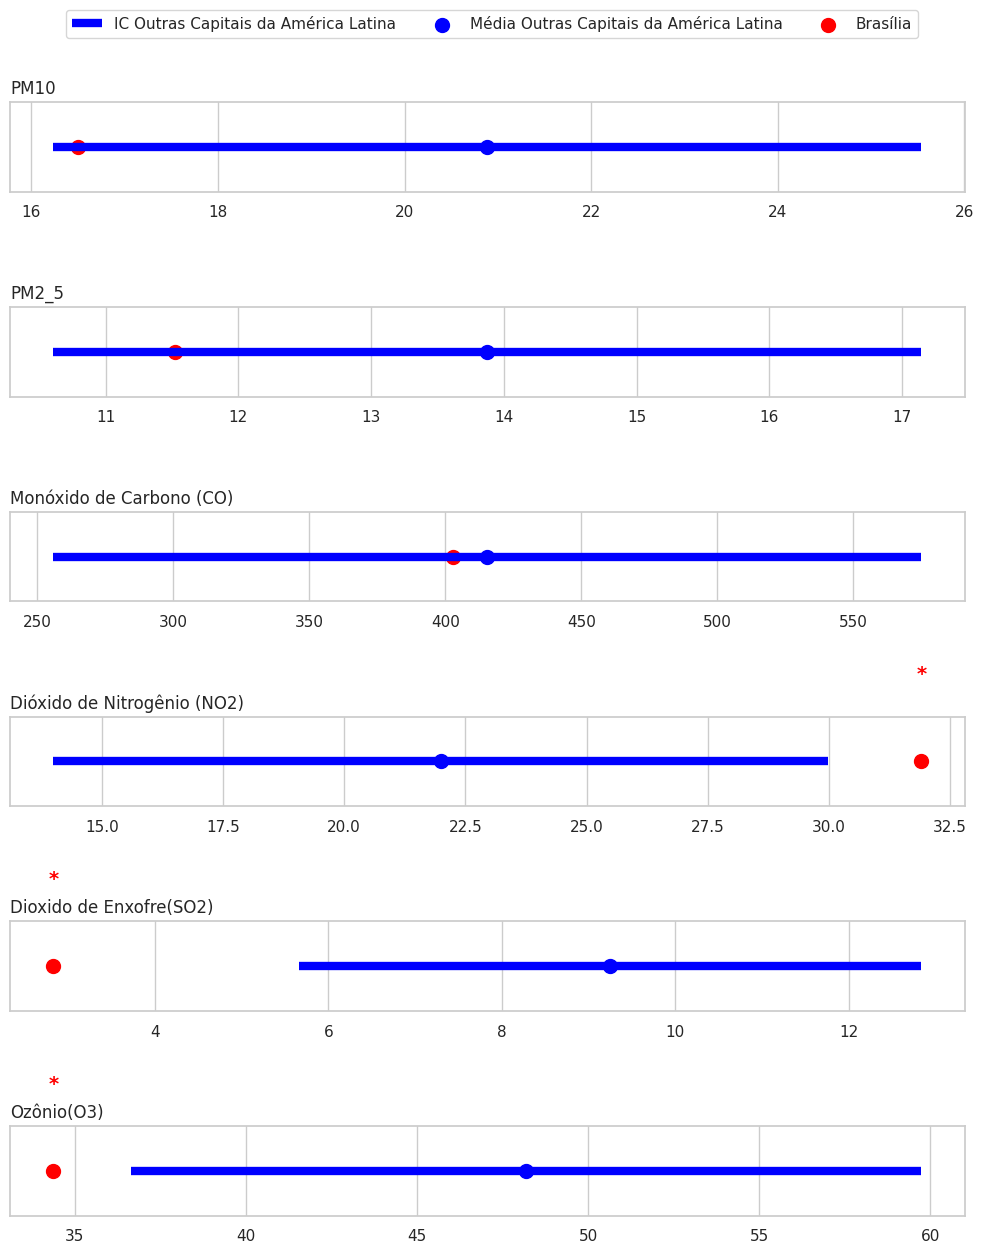

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Função IC
def ic_media(data, confianca=0.95):
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    h = sem * stats.t.ppf((1 + confianca) / 2., n-1)
    return mean, mean - h, mean + h

# Preparar dados
poluentes = []
medias_outras = []
ic_outras = []
brasilia_valores = []

for poluente in indicadores_poluicao:
    mean_o, lower_o, upper_o = ic_media(outras[poluente])
    val_b = brasilia[poluente].iloc[0]

    poluentes.append(poluente)
    medias_outras.append(mean_o)
    ic_outras.append((lower_o, upper_o))
    brasilia_valores.append(val_b)

# --- Plot horizontal ---
fig, axes = plt.subplots(len(indicadores_poluicao), 1, figsize=(10, 2*len(indicadores_poluicao)), sharex=False)

for i, poluente in enumerate(indicadores_poluicao):
    lower, upper = ic_outras[i]
    mean_o = medias_outras[i]
    val_b = brasilia_valores[i]

    # IC das outras cidades (barra horizontal)
    axes[i].hlines(y=0.5, xmin=lower, xmax=upper, color='blue', lw=6, label='IC Outras Capitais da América Latina')
    axes[i].scatter(mean_o, 0.5, color='blue', s=100, label='Média Outras Capitais da América Latina')
    axes[i].scatter(val_b, 0.5, color='red', s=100, label='Brasília')

    # Marcar com asterisco se Brasília estiver fora do IC
    if val_b < lower or val_b > upper:
        axes[i].text(val_b, 0.55, '*', color='red', fontsize=14, fontweight='bold', ha='center')

    axes[i].set_yticks([])
    axes[i].set_title(poluente, loc='left')

# Colocar legenda **acima de todos os subplots**
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()


Isso nos traz uma boa intuição, mas é preciso realizar um teste de hipótese formal para tirar conclusões.

# **Teste de Hipóteses**

Hipótese nula (H0): A média de Brasília é igual à média das outras capitais da América Latina.

Hipótese alternativa (H1): A média de Brasília é diferente da média das outras capitais da América Latina.

In [ ]:
brasilia_valores=dados_clima[dados_clima['Cidade']=='Brasília']
outras_valores=dados_clima[dados_clima['Cidade']!='Brasília']

Primeiramente, verifica se as variâncias são iguais ou diferentes.

In [ ]:
import numpy as np
from scipy.stats import f
print("--- Teste de Variância ---\n")
for poluente in indicadores_poluicao:

  print(f"Poluente: {poluente}")
  # --- Dados das amostras ---
  amostra1 = np.array(brasilia_valores[poluente].dropna().values)
  amostra2 = np.array(outras_valores[poluente].dropna().values)

  n1 = len(amostra1)
  n2 = len(amostra2)

  s1_sq = np.var(amostra1, ddof=1)  # Variância amostral
  s2_sq = np.var(amostra2, ddof=1)

  # --- Teste F ---
  F_obs = s1_sq / s2_sq
  alpha = 0.05

  # Graus de liberdade
  df1 = n1 - 1
  df2 = n2 - 1

  # Valores críticos para teste bilateral
  F_lower = f.ppf(alpha/2, df1, df2)
  F_upper = f.ppf(1 - alpha/2, df1, df2)

  print(f"Variâncias amostrais: s1^2 = {s1_sq:.2f}, s2^2 = {s2_sq:.2f}")
  print(f"Estatística F observada: {F_obs:.2f}")
  print(f"Região de aceitação: [{F_lower:.2f}, {F_upper:.2f}]")

  if F_obs < F_lower or F_obs > F_upper:
      print("Rejeita H0: variâncias diferentes")
  else:
      print("Não rejeita H0: variâncias podem ser iguais")
  print("\n")


--- Teste de Variância ---

Poluente: PM10
Variâncias amostrais: s1^2 = 72.98, s2^2 = 295.17
Estatística F observada: 0.25
Região de aceitação: [0.89, 1.12]
Rejeita H0: variâncias diferentes


Poluente: PM2_5
Variâncias amostrais: s1^2 = 35.50, s2^2 = 141.11
Estatística F observada: 0.25
Região de aceitação: [0.89, 1.12]
Rejeita H0: variâncias diferentes


Poluente: Monóxido de Carbono (CO)
Variâncias amostrais: s1^2 = 32295.21, s2^2 = 258035.90
Estatística F observada: 0.13
Região de aceitação: [0.89, 1.12]
Rejeita H0: variâncias diferentes


Poluente: Dióxido de Nitrogênio (NO2)
Variâncias amostrais: s1^2 = 317.33, s2^2 = 628.18
Estatística F observada: 0.51
Região de aceitação: [0.89, 1.12]
Rejeita H0: variâncias diferentes


Poluente: Dioxido de Enxofre(SO2)
Variâncias amostrais: s1^2 = 1.75, s2^2 = 194.68
Estatística F observada: 0.01
Região de aceitação: [0.89, 1.12]
Rejeita H0: variâncias diferentes


Poluente: Ozônio(O3)
Variâncias amostrais: s1^2 = 448.63, s2^2 = 1071.74
Estat

Agora, fazemos o teste t para comparação das médias de duas populações, para variâncias desconhecidas e diferentes.

In [ ]:
from scipy.stats import ttest_ind
resultados = []

for poluente in indicadores_poluicao:
    # Pegando apenas os valores do poluente
    b = brasilia_valores[poluente].dropna()
    o = outras_valores[poluente].dropna()

    # Teste t de Welch (comparacao das médias; variâncias desconhecidas e diferentes)
    t_stat, p_val = ttest_ind(b, o, equal_var=False)

    resultados.append({
        'Poluente': poluente,
        'Média Brasília': b.mean(),
        'Média das Outras Capitais da América Latina': o.mean(),
        't-Statistic': t_stat,
        'p-Valor': p_val
    })

# Transformar em DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados


Poluente  Média Brasília  \
0                         PM10       16.501438   
1                        PM2_5       11.519010   
2     Monóxido de Carbono (CO)      402.910543   
3  Dióxido de Nitrogênio (NO2)       31.909824   
4      Dioxido de Enxofre(SO2)        2.828275   
5                   Ozônio(O3)       34.373802   

   Média das Outras Capitais da América Latina  t-Statistic       p-Valor  
0                                    20.889003   -11.667822  1.986847e-29  
1                                    13.876400    -9.002231  1.263986e-18  
2                                   415.535480    -1.474767  1.405271e-01  
3                                    21.987977    13.261770  2.893329e-36  
4                                     9.251522   -46.402395  0.000000e+00  
5                                    48.190012   -15.382038  6.581365e-47

In [ ]:
print("Conclusões: \n")
for i in range(len(df_resultados)):
    p_val = df_resultados.loc[i, 'p-Valor']
    poluente = df_resultados.loc[i, 'Poluente']

    if not np.isnan(p_val) and p_val < 0.05: #p-valor < 0.05
        print(f"A diferença entre a média de Brasília e das outras capitais da América Latina para {poluente} é significativa a um nível de confiança de 5%.")
    else:
        print(f"Não há evidência suficiente para afirmar que a média de Brasília é diferente da média das outras capitais da América Latina para {poluente} a um nível de significância de 5%.")

Conclusões: 

A diferença entre a média de Brasília e das outras capitais da América Latina para PM10 é significativa a um nível de confiança de 5%.
A diferença entre a média de Brasília e das outras capitais da América Latina para PM2_5 é significativa a um nível de confiança de 5%.
Não há evidência suficiente para afirmar que a média de Brasília é diferente da média das outras capitais da América Latina para Monóxido de Carbono (CO) a um nível de significância de 5%.
A diferença entre a média de Brasília e das outras capitais da América Latina para Dióxido de Nitrogênio (NO2) é significativa a um nível de confiança de 5%.
A diferença entre a média de Brasília e das outras capitais da América Latina para Dioxido de Enxofre(SO2) é significativa a um nível de confiança de 5%.
A diferença entre a média de Brasília e das outras capitais da América Latina para Ozônio(O3) é significativa a um nível de confiança de 5%.


# **Correlações**

2- Avaliar correlações entre os gases e as variáveis do tempo.

✅ Matriz de Correlação calculada com sucesso.


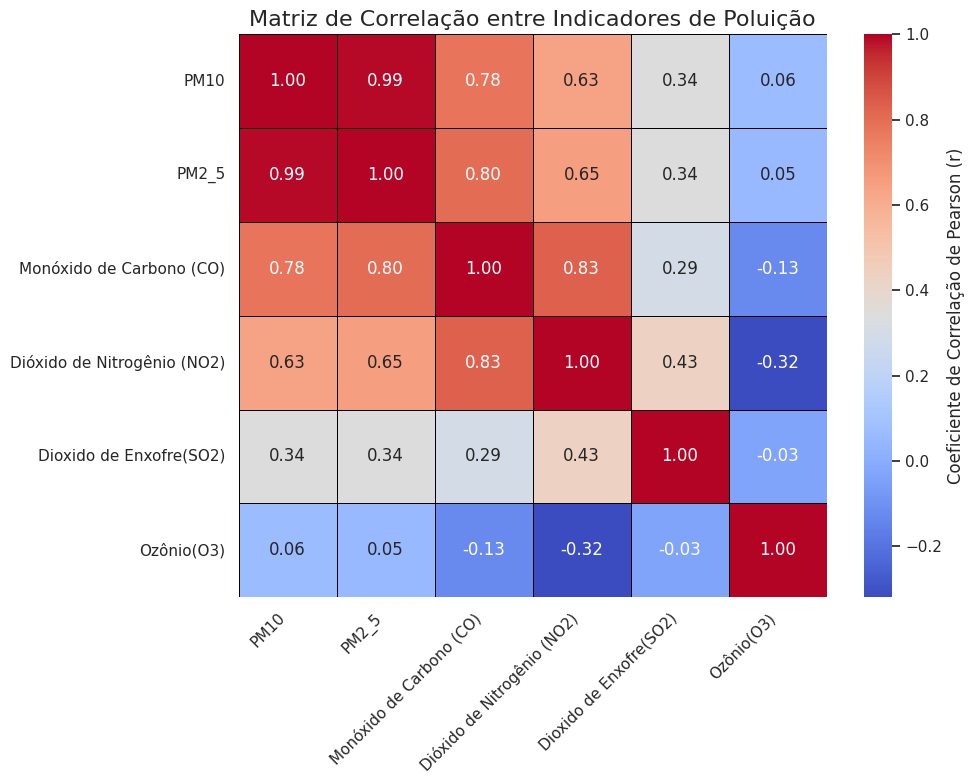


📈 Pares de Variáveis com Correlação Forte (|r| > 0.7):
  PM2_5 vs PM10: 0.99
  Dióxido de Nitrogênio (NO2) vs Monóxido de Carbono (CO): 0.83
  Monóxido de Carbono (CO) vs PM2_5: 0.80
  Monóxido de Carbono (CO) vs PM10: 0.78


In [ ]:
# --- 0. PREPARAÇÃO DE DADOS ---

# 1. Definir os Indicadores de Interesse (mesma lista usada no Pair Plot)
# Ajuste esta lista para os nomes exatos das colunas no seu DataFrame.
INDICADORES_PARA_CORRELACAO = ['PM10', 'PM2_5', 'Monóxido de Carbono (CO)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']

# 2. Filtrar o DataFrame para incluir apenas as colunas de interesse
df_corr = dados_clima.copy()

# Remove colunas que não existem nos dados
colunas_presentes = [col for col in INDICADORES_PARA_CORRELACAO if col in df_corr.columns]
df_corr = df_corr[colunas_presentes]

# 3. Calcular a Matriz de Correlação
# O método .corr() do Pandas calcula o coeficiente de Pearson entre todos os pares
matriz_correlacao = df_corr.corr(numeric_only=True)

print("✅ Matriz de Correlação calculada com sucesso.")
# print(matriz_correlacao) # Descomente para ver a tabela de números

# --- 4. GERAÇÃO DO HEATMAP (Mapa de Calor) ---

plt.figure(figsize=(10, 8))

sns.heatmap(
    matriz_correlacao,
    annot=True,              # Mostra o valor numérico (coeficiente r) em cada célula
    cmap='coolwarm',         # Paleta de cores que destaca correlações positivas (quente/vermelho) e negativas (frio/azul)
    fmt=".2f",               # Formato de duas casas decimais para os números
    linewidths=.5,           # Linhas para separar as células
    linecolor='black',       # Cor das linhas
    cbar_kws={'label': 'Coeficiente de Correlação de Pearson (r)'} # Rótulo da barra de cor
)

plt.title('Matriz de Correlação entre Indicadores de Poluição', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# --- 5. Análise Opcional: Filtro de Alta Correlação ---
# Para simplificar a análise, você pode extrair pares com alta correlação (|r| > 0.7)

matriz_upper = matriz_correlacao.where(np.triu(np.ones(matriz_correlacao.shape), k=1).astype(bool))
pares_altamente_correlacionados = matriz_upper.unstack().sort_values(ascending=False).dropna()

print("\n📈 Pares de Variáveis com Correlação Forte (|r| > 0.7):")
for index, valor in pares_altamente_correlacionados.items():
    if abs(valor) >= 0.7:
        print(f"  {index[0]} vs {index[1]}: {valor:.2f}")

##**Regressão:**

1- É possível desenvolver um modelo de regressão que preveja os níveis de PM2.5 para cidades da América Latina, usando dados meteorológicos e históricos como entrada?

2- Quais variáveis meteorológicas (temperatura, velocidade do vento, pressão atmosférica) são os preditores mais importantes para a qualidade do ar, e essa importância varia entre as diferentes regiões ?